In [2]:
import os
import re
import io
import json
from numba import njit
from io import StringIO
from pathlib import Path
from numbers import Number
from itertools import combinations
from contextlib import redirect_stdout

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde, skew
from scipy.special import logsumexp, softmax
from scipy.optimize import minimize, LinearConstraint, Bounds

from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from mpl_toolkits.axes_grid1 import make_axes_locatable


DATA_DIR = Path("data/processed_portfolio_returns")

In [3]:
ordered_cols = [
    "reb_freq", "window", "data_freq", "N",
    "mu", "std",
    "CR", "SR", "SR_pen",
    "dispersion", "MDD", "|MDD|", "VaR"
]
metric_map = {
    "mu":  r"$\mu$",
    "std": r"$\sigma$",
    "CR":  "CR",
    "SR":  "SR",
    "SR_pen": r"SR$_p$",
    "dispersion": "Disp.",
    "MDD": "DD",
    "|MDD|": r"\textbar DD\textbar",
    "VaR": "VaR",
    "reb_freq": "Reb.",
    "data_freq": "Data",
    "window": "Wnd.",
    "N": "N",
}
portfolio_map = {
    "value": "VW",
    "min_var": "MV",
    "markowitz": "MAR",
    "max_sharpe": "TAN",
    "kde": "KDE",
    "gmm": "GMM",
    "kde_max_sharpe": "TAN(KDE)",
    "gmm_max_sharpe": "TAN(GMM)",
}
column_rename_map = {
    "CR": "CR",
    "SR": "SR",
    "SR_pen": r"SR$_p$",
    "dispersion": "Disp.",
    "MDD": "DD",
    "|MDD|": r"\textbar DD\textbar",
    "mu": r"$\mu$",
    "sigma": r"$\sigma$",
    "VaR": "VaR",
    "reb_freq": "Reb.",
    "data_freq": "Data",
    "window": "Wnd.",
    "N": "N"
}
row_rename_map = {
    "value": "VW",
    "min_var": "MV",
    "markowitz": "MAR",
    "max_sharpe": "TAN",
    "kde": "KDE",
    "gmm": "GMM",
    "kde_max_sharpe": "TAN(KDE)",
    "gmm_max_sharpe": "TAN(GMM)"
}
good_metrics = {"mu", "std", "CR", "SR", "SR_pen"}
bad_metrics  = {"dispersion", "MDD", "|MDD|", "VaR"}

def df_to_latex(df: pd.DataFrame,
                float_format: str = "{:.4f}",
                filename: str = None) -> str:
    ordered_cols = [
        "reb_freq", "window", "data_freq", "N",
        "mu", "std",
        "CR", "SR", "SR_pen",
        "dispersion", "MDD", "|MDD|", "VaR"
    ]
    metric_map = {
        "mu":  r"$\mu$",
        "std": r"$\sigma$",
        "CR":  "CR",
        "SR":  "SR",
        "SR_pen": r"SR$_p$",
        "dispersion": "Disp.",
        "MDD": "DD",
        "|MDD|": r"\textbar DD\textbar",
        "VaR": "VaR",
        "reb_freq": "Reb.",
        "data_freq": "Data",
        "window": "Wnd.(mo)",
        "N": "N",
    }
    portfolio_map = {
        "value": "VW",
        "min_var": "MV",
        "markowitz": "MAR",
        "max_sharpe": "TAN",
        "kde": "KDE",
        "gmm": "GMM",
        "kde_max_sharpe": "TAN(KDE)",
        "gmm_max_sharpe": "TAN(GMM)",
    }
    good_metrics = {"mu", "CR", "SR", "SR_pen"}
    bad_metrics  = {"dispersion",  "std", "MDD", "|MDD|", "VaR"}
    
    def to_months(window_str):
        if window_str is None or pd.isna(window_str):
            return ""
            
        if isinstance(window_str, (int, float)):
            return int(window_str)
        
        if not isinstance(window_str, str):
            return window_str
            
        try:
            if window_str[1].isnumeric():
                size_part = window_str[:2]
                unit_part = window_str[2:]
            else:
                size_part = window_str[:1]
                unit_part = window_str[1:]
                
            size = int(size_part)
            
            if unit_part == "months":
                return size
            elif unit_part == "years":
                return size * 12
            else:
                return window_str
        except (IndexError, ValueError):
            return window_str
    
    df2 = df.rename(index=portfolio_map).copy()
    
    if "window" in df.columns:
        df2["window_months"] = df["window"].apply(to_months)
    
    df2 = df2.rename(columns=metric_map)
    
    if "window_months" in df2.columns:
        df2["Wnd.(mo)"] = df2["window_months"]
        df2 = df2.drop(columns=["window_months"])
    
    present = [metric_map.get(c, c) for c in df.columns if c in metric_map]
    df2 = df2[present]
    df2.index.name = ""
    
    bests = {}
    for orig, disp in zip(df.columns, present):
        if orig in good_metrics or orig in bad_metrics:
            vals = pd.to_numeric(df[orig], errors='coerce')
            if orig in good_metrics:
                bests[disp] = vals.max()
            elif orig in bad_metrics:
                bests[disp] = vals.min()
    
    num_cols = len(present)
    spec = "l" + "*{" + str(num_cols) + "}{S[table-format=1.4]}"
    buf = StringIO()
    buf.write("\\begin{tabular}{" + spec + "}\n")
    buf.write("  \\toprule\n")
    
    header_items = []
    for h in present:
        header_items.append("{" + h + "}")
    centered = " & ".join(header_items)
    header_tmpl = "  & {CENTERED} \\\\"
    buf.write(header_tmpl.replace("{CENTERED}", centered) + "\n")
    buf.write("  \\midrule\n")
    
    row_tmpl = "  {IDX} & {VALUES} \\\\"
    for idx, row in df2.iterrows():
        vals = []
        for h in present:
            v = row[h]
            if pd.isna(v):
                vals.append("{}")
            elif isinstance(v, Number):
                txt = float_format.format(float(v))
                if h in bests and abs(float(v) - bests[h]) < 1e-6:
                    txt = "{\\bfseries " + txt + "}"
                vals.append(txt)
            else:
                vals.append("{" + str(v) + "}")
        line = row_tmpl.replace("{IDX}", str(idx)).replace("{VALUES}", " & ".join(vals))
        buf.write(line + "\n")
    
    buf.write("  \\bottomrule\n")
    buf.write("\\end{tabular}\n")
    latex = buf.getvalue()
    
    if filename:
        os.makedirs("report/tables", exist_ok=True)
        with open(os.path.join("report/tables", filename), 'w', encoding='utf-8') as f:
            f.write(latex)
    
    return latex

def df_to_latex_alt(df: pd.DataFrame,
                float_format: str = "{:.4f}",
                filename: str = None,
                rank_mode: bool = False) -> str:
    ordered_cols = [
        "reb_freq", "window", "data_freq", "N",
        "mu", "std",
        "CR", "SR", "SR_pen",
        "dispersion", "MDD", "|MDD|", "VaR"
    ]
    metric_map = {
        "mu":  r"$\mu$",
        "std": r"$\sigma$",
        "CR":  "CR",
        "SR":  "SR",
        "SR_pen": r"SR$_p$",
        "dispersion": "Disp.",
        "MDD": "DD",
        "|MDD|": r"\textbar DD\textbar",
        "VaR": "VaR",
        "reb_freq": "Reb.",
        "data_freq": "Data",
        "window": "Wnd.(mo)",
        "N": "N",
    }
    portfolio_map = {
        "value": "VW",
        "min_var": "MV",
        "markowitz": "MAR",
        "max_sharpe": "TAN",
        "kde": "KDE",
        "gmm": "GMM",
        "kde_max_sharpe": "TAN(KDE)",
        "gmm_max_sharpe": "TAN(GMM)",
    }
    good_metrics = {"mu", "CR", "SR", "SR_pen"}
    bad_metrics  = {"dispersion", "std", "MDD", "|MDD|", "VaR"}
    
    def to_ordinal(n):
        if n > 10:
            return str(n)
            
        suffixes = {1: "st", 2: "nd", 3: "rd"}
        if 11 <= n <= 13:
            suffix = "th"
        else:
            suffix = suffixes.get(n % 10, "th")
        return f"{n}{suffix}"
    
    def to_months(window_str):
        if window_str is None or pd.isna(window_str):
            return ""
            
        if isinstance(window_str, (int, float)):
            return int(window_str)
        
        if not isinstance(window_str, str):
            return window_str
            
        try:
            if window_str[1].isnumeric():
                size_part = window_str[:2]
                unit_part = window_str[2:]
            else:
                size_part = window_str[:1]
                unit_part = window_str[1:]
                
            size = int(size_part)
            
            if unit_part == "months":
                return size
            elif unit_part == "years":
                return size * 12
            else:
                return window_str
        except (IndexError, ValueError):
            return window_str
    
    df2 = df.rename(index=portfolio_map).copy()
    
    if "window" in df.columns:
        df2["window_months"] = df["window"].apply(to_months)
    
    df2 = df2.rename(columns=metric_map)
    
    if "window_months" in df2.columns:
        df2["Wnd.(mo)"] = df2["window_months"]
        df2 = df2.drop(columns=["window_months"])
    
    present = [metric_map.get(c, c) for c in df.columns if c in metric_map]
    df2 = df2[present]
    df2.index.name = ""
    
    bests = {}
    for orig, disp in zip(df.columns, present):
        if orig in good_metrics or orig in bad_metrics:
            vals = pd.to_numeric(df[orig], errors='coerce')
            if orig in good_metrics:
                bests[disp] = vals.max()
            elif orig in bad_metrics:
                bests[disp] = vals.min()
    
    rank_df = pd.DataFrame(index=df2.index)
    contested_ranks = {}
    rankable_cols = []
    avg_rank_positions = None
    
    if rank_mode:
        for h in present:
            if h in bests:
                rankable_cols.append(h)
                values = pd.to_numeric(df2[h], errors='coerce')
                if h in [metric_map[m] for m in good_metrics if m in metric_map]:
                    ranks = values.rank(ascending=False, method='min').astype(int)
                else:
                    ranks = values.rank(ascending=True, method='min').astype(int)
                rank_df[h] = ranks
                
                value_counts = ranks.value_counts()
                contested = value_counts[value_counts > 1].index.tolist()
                contested_ranks[h] = set(contested)  
        
        if rankable_cols:
            rank_df['Avg. Rank'] = rank_df[rankable_cols].mean(axis=1).round(2)
            
            avg_rank_positions = rank_df['Avg. Rank'].rank(method='min').astype(int)
            
            value_counts = avg_rank_positions.value_counts()
            contested = value_counts[value_counts > 1].index.tolist()
            contested_ranks['Avg. Rank'] = set(contested)
    
    num_cols = len(present)
    
    if rank_mode:
        spec = "l|c|*{" + str(num_cols) + "}{S[table-format=1.4]}"
    else:
        spec = "l" + "*{" + str(num_cols) + "}{S[table-format=1.4]}"
    
    buf = StringIO()
    buf.write("\\begin{tabular}{" + spec + "}\n")
    buf.write("  \\toprule\n")
    
    header_items = []
    for h in present:
        header_items.append("{" + h + "}")
    
    if rank_mode:
        header_tmpl = "  & {Avg. Rank} & {CENTERED} \\\\"
    else:
        header_tmpl = "  & {CENTERED} \\\\"
        
    buf.write(header_tmpl.replace("{CENTERED}", " & ".join(header_items)) + "\n")
    buf.write("  \\midrule\n")
    
    if rank_mode:
        row_tmpl = "  {IDX} & {AVG_RANK} & {VALUES} \\\\"
    else:
        row_tmpl = "  {IDX} & {VALUES} \\\\"
    
    for idx, row in df2.iterrows():
        vals = []
        for h in present:
            v = row[h]
            if pd.isna(v):
                vals.append("{}")
            elif isinstance(v, Number):
                if rank_mode and h in rank_df.columns:
                    rank = rank_df.loc[idx, h]
                    txt = to_ordinal(rank)
                    
                    is_contested = rank in contested_ranks.get(h, set())
                    
                    if h in bests and rank == 1:
                        txt = "{\\bfseries " + txt + "}"
                    elif is_contested:
                        txt = "{\\textit{" + txt + "}}"
                    
                    vals.append("{" + txt + "}")  
                else:
                    txt = float_format.format(float(v))
                    if h in bests and abs(float(v) - bests[h]) < 1e-6:
                        txt = "{\\bfseries " + txt + "}"
                    vals.append(txt)
            else:
                vals.append("{" + str(v) + "}")  
        
        if rank_mode:
            avg_rank_pos = avg_rank_positions.loc[idx]
            
            avg_rank_txt = to_ordinal(avg_rank_pos)
            
            is_contested = avg_rank_pos in contested_ranks.get('Avg. Rank', set())
            
            if avg_rank_pos == 1:
                avg_rank_txt = "{\\bfseries " + avg_rank_txt + "}"
            elif is_contested:
                avg_rank_txt = "{\\textit{" + avg_rank_txt + "}}"
                
            line = row_tmpl.replace("{IDX}", str(idx)) \
                          .replace("{AVG_RANK}", "{" + avg_rank_txt + "}") \
                          .replace("{VALUES}", " & ".join(vals))
        else:
            line = row_tmpl.replace("{IDX}", str(idx)) \
                          .replace("{VALUES}", " & ".join(vals))
            
        buf.write(line + "\n")
    
    buf.write("  \\bottomrule\n")
    buf.write("\\end{tabular}\n")
    latex = buf.getvalue()
    
    if filename:
        os.makedirs("report/tables", exist_ok=True)
        with open(os.path.join("report/tables", filename), 'w', encoding='utf-8') as f:
            f.write(latex)
    
    return latex

def df_config_to_latex(df: pd.DataFrame,
                        float_format: str = "{:.4f}",
                        filename: str = None) -> str:
    """
    Convert configuration DataFrame to a LaTeX table with proper alignment using siunitx.
    Specially designed for portfolio configuration tables with window values.
    """
    df2 = df.copy()
    
    bests = {}
    for col in df.columns:
        if col == 'SR' or col == 'SR_pen':
            bests[col] = df[col].max()
    
    column_map = {
        "reb_freq": "Reb.",
        "window": "Wnd.(mo)",
        "data_freq": "Data",
        "SR": "SR",
        "SR_pen": r"SR$_p$"
    }
    df2 = df2.rename(columns=column_map)
    
    if 'SR_pen' in bests:
        bests[r"SR$_p$"] = bests.pop('SR_pen')
    
    index_map = {
        "value": "VW",
        "min_var": "MV",
        "markowitz": "MAR",
        "max_sharpe": "TAN",
        "kde": "KDE",
        "gmm": "GMM",
        "kde_max_sharpe": "TAN(KDE)",
        "gmm_max_sharpe": "TAN(GMM)"
    }
    df2 = df2.rename(index=index_map)
    
    num_cols = len(df2.columns)
    spec = "l" + "*{" + str(num_cols) + "}{S[table-format=1.4]}"
    
    buf = StringIO()
    buf.write("\\begin{tabular}{" + spec + "}\n")
    buf.write("  \\toprule\n")
    
    header_items = ["{" + col + "}" for col in df2.columns]
    buf.write("  & " + " & ".join(header_items) + " \\\\\n")
    buf.write("  \\midrule\n")
    
    for idx, row in df2.iterrows():
        values = []
        for col in df2.columns:
            val = row[col]
            
            if pd.isna(val):
                formatted = "{}"
            elif col == "Wnd.(mo)" and isinstance(val, (int, float)):
                formatted = "{" + str(int(val)) + "}"
            elif isinstance(val, (int, float)):
                if col in bests and abs(val - bests[col]) < 1e-6:
                    formatted = "{\\bfseries " + float_format.format(val) + "}"
                else:
                    formatted = float_format.format(val)
            else:
                formatted = "{" + str(val) + "}"
            
            values.append(formatted)
        
        buf.write("  " + str(idx) + " & " + " & ".join(values) + " \\\\\n")
    
    buf.write("  \\bottomrule\n")
    buf.write("\\end{tabular}\n")
    latex = buf.getvalue()
    
    if filename:
        os.makedirs("report/tables", exist_ok=True)
        with open(os.path.join("report/tables", filename), 'w', encoding='utf-8') as f:
            f.write(latex)
    
    return latex

def normalize_df(df, method='minmax', fudge=1.0):
    if method == 'minmax':
        df = (df - (df.min() / fudge)) / (df.max() - (df.min() / fudge))
    elif method == 'rank':
        df = df.rank(pct=True)
    else:
        raise ValueError("Normalization method must be 'minmax' or 'rank'")
    return df
    
def radar(result_df, keys=None, normalize=True, method='rank', fudge=1.0, title="Radar Plot of Portfolio Metrics", save_path=None, left=False):
    """
    Plots a radar chart of selected portfolio metrics.

    Parameters:
    - result_df: DataFrame where index is keys and columns are metrics.
    - keys: List of keys to plot. If None, plot all.
    - normalize: Whether to normalize metrics.
    - method: Normalization method: 'minmax' or 'rank'
    - fudge: Fudge factor used in 'minmax' normalization.
    - title: Title of the radar plot.
    """
    df_plot = result_df.copy()
    
    metrics = df_plot.columns.tolist()

    if normalize:
        df_plot = normalize_df(df_plot, method=method, fudge=fudge)
    if keys is None:
        keys = df_plot.index.tolist()
    else:
        df_plot = df_plot.loc[keys]



    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    if metric_map is not None:
        renamed_metrics = [metric_map.get(m, m) for m in metrics]
    else:
        renamed_metrics = metrics

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for portfolio in keys:
        values = df_plot.loc[portfolio].tolist()
        values += values[:1]
        label = portfolio_map.get(portfolio, portfolio) if portfolio_map else portfolio
        ax.plot(angles, values, label=label)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(renamed_metrics)
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_yticklabels([])

    ax.set_ylabel("")

    if left:
        ax.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.1))
    else:
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

    plt.tight_layout()

    if save_path:
        img_path = f'report/images/{save_path}'
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        print(f"Radar plot saved to {img_path}")

    plt.show()

def dual_radar(result_df, left, right, 
               normalize=True, method='rank', fudge=1.0, 
               title_left="Radar Plot - KDE Portfolios", 
               title_right="Radar Plot - GMM Portfolios",
               save_path=None):

    df_plot = result_df.copy()
    metrics = df_plot.columns.tolist()
    
    if normalize:
        df_plot = normalize_df(df_plot, method=method, fudge=fudge)

    if metric_map is not None:
        renamed_metrics = [metric_map.get(m, m) for m in metrics]
    else:
        renamed_metrics = metrics

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True))

    for ax, portfolios, title in zip(axes, [left, right], [title_left, title_right]):
        for portfolio in portfolios:
            values = df_plot.loc[portfolio].tolist()
            values += values[:1]
            label = portfolio_map.get(portfolio, portfolio) if portfolio_map else portfolio
            ax.plot(angles, values, label=label)
            ax.fill(angles, values, alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(renamed_metrics)
        ax.set_title(title, fontsize=14, pad=20)
        ax.set_yticklabels([])

        if ax is axes[0]:
            ...
            ax.legend(loc='upper left')
            ax.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.1))
        else:
            ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()

    if save_path:
        img_path = f'report/images/{save_path}'
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        print(f"Dual radar plots saved to {img_path}")

    plt.show()

def sr_srpen(df, title="Sharpe Ratios by Portfolio", save_path=None):
    """
    Plots a vertical bar chart with SR and SR_pen per portfolio.

    Parameters:
    - df: DataFrame with columns ['Portfolio', 'SR', 'SR_pen']
    - title: Title of the plot
    """
    portfolios = df.index.tolist()
    SR = df['SR'].tolist()
    SR_pen = df['SR_pen'].tolist()

    x = np.arange(len(portfolios))
    width = 0.35

    cmap = plt.colormaps['bwr']
    color_sr = cmap(0.2)
    color_srpen = cmap(0.8)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, SR, width, label='SR', color=color_sr)
    ax.bar(x + width/2, SR_pen, width, label='SR_pen', color=color_srpen)

    ax.set_ylabel('Sharpe Ratio')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(portfolios, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    
    if save_path:
        img_path = f'report/images/{save_path}'
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        print(f"Radar plot saved to {img_path}")
    plt.show()

def add_centered_cbar(ax, hm, norm, cmap="bwr_r", size="4%", pad=0.25, eps=1e-9):
    """Attach a symmetric, clipped colorbar to the right of ax."""
    divider = make_axes_locatable(ax)
    cax     = divider.append_axes("right", size=size, pad=pad)
    sm      = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cb      = ax.figure.colorbar(sm, cax=cax)
    lo, hi  = min(np.nanmin(hm), 0), max(np.nanmax(hm), 0)
    if lo == hi: lo, hi = -eps, eps
    cb.ax.set_ylim(lo, hi)
    ticks = sorted({lo, 0, hi})
    cb.set_ticks(ticks)
    cb.set_ticklabels([f"{t:.2g}" for t in ticks])
    cb.ax.set_ylabel(None, rotation=270, labelpad=18, weight="bold")

def two_slope_norm(hm, eps=1e-9):
    data = hm.to_numpy()
    lo, hi = np.nanmin(data), np.nanmax(data)
    m = np.nanmax(np.abs([lo, hi, 0])) or eps
    return mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-m, vmax=m)

def create_combined_index_table(results_by_index, indices, float_format="{:.4f}", filename=None):
    """Create a combined LaTeX table with indices in multirow cells on the side, sorted by SR."""
    metrics = ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|']
    
    good_metrics = {"mu", "CR", "SR"}
    bad_metrics = {"dispersion", "std", "MDD", "|MDD|", "VaR"}
    
    metric_map = {
        "mu": r"$\mu$",
        "std": r"$\sigma$",
        "CR": "CR",
        "SR": "SR",
        "VaR": "VaR",
        "MDD": "DD",
        "|MDD|": r"\textbar DD\textbar",
    }
    
    portfolio_map = {
        "value": "VW",
        "min_var": "MV",
        "markowitz": "MAR",
        "max_sharpe": "TAN",
        "kde": "KDE",
        "gmm": "GMM",
        "kde_max_sharpe": "TAN(KDE)",
        "gmm_max_sharpe": "TAN(GMM)",
    }
    
    index_display = {
        "S&P500": r"S\&P500",
        "FTSE100": "FTSE100",
        "HSI": "HSI",
        "STOXX50": "STOXX50"
    }
    
    bests = {}
    sorted_data = {}
    
    for idx in indices:
        bests[idx] = {}
        df = results_by_index[idx]
        
        sorted_df = df.sort_values(by='SR', ascending=False)
        if 'equal' in sorted_df.index:
            sorted_df = sorted_df.drop('equal')
            
        sorted_data[idx] = sorted_df
        
        for metric in metrics:
            if metric in good_metrics:
                bests[idx][metric] = sorted_df[metric].max()
            elif metric in bad_metrics:
                bests[idx][metric] = sorted_df[metric].min()
    
    buf = StringIO()
    
    spec = "ll" + "*{" + str(len(metrics)) + "}{S[table-format=1.4]}"
    buf.write("\\begin{tabular}{" + spec + "}\n")
    buf.write("  \\toprule\n")
    
    buf.write("  Index & Strategy & ")
    for m_i, metric in enumerate(metrics):
        display_name = metric_map.get(metric, metric)
        buf.write(f"{{{display_name}}}")
        if m_i < len(metrics) - 1:
            buf.write(" & ")
    buf.write(" \\\\\n")
    buf.write("  \\midrule\n")
    
    for idx_i, idx in enumerate(indices):
        display_idx = index_display.get(idx, idx)
        
        sorted_df = sorted_data[idx]
        portfolios = sorted_df.index.tolist()
        num_portfolios = len(portfolios)
        
        for p_i, portfolio in enumerate(portfolios):
            portfolio_display = portfolio_map.get(portfolio, portfolio)
            
            if p_i == 0:
                buf.write(f"  \\multirow{{{num_portfolios}}}{{*}}{{\\textbf{{{display_idx}}}}} & {portfolio_display} & ")
            else:
                buf.write(f"   & {portfolio_display} & ")
            
            for m_i, metric in enumerate(metrics):
                value = sorted_df.loc[portfolio, metric]
                
                if pd.isna(value):
                    formatted = "{}"
                elif isinstance(value, (int, float)):
                    if metric in bests[idx] and abs(value - bests[idx][metric]) < 1e-6:
                        formatted = "{\\bfseries " + float_format.format(value) + "}"
                    else:
                        formatted = float_format.format(value)
                else:
                    formatted = "{" + str(value) + "}"
                
                buf.write(formatted)
                
                if m_i < len(metrics) - 1:
                    buf.write(" & ")
            
            buf.write(" \\\\\n")
        
        if idx_i < len(indices) - 1:
            buf.write("  \\midrule\n")
    
    buf.write("  \\bottomrule\n")
    buf.write("\\end{tabular}\n")
    latex = buf.getvalue()
    
    if filename:
        os.makedirs("report/tables", exist_ok=True)
        with open(os.path.join("report/tables", filename), 'w', encoding='utf-8') as f:
            f.write(latex)
    
    return latex

def plot_cumulative_envelope(returns_df, median_only=[], with_envelope=[], title="Cumulative Returns", ylim=None, save_path=None):
    """
    Plot cumulative returns with optional envelopes using a pre-loaded DataFrame.
    
    Parameters:
    -----------
    returns_df : pandas.DataFrame
        DataFrame containing returns data with columns named as {portfolio}_{median/min/max}
    median_only : list
        List of portfolio names to plot only the median line
    with_envelope : list
        List of portfolio names to plot with min/max envelope
    title : str
        Plot title
    ylim : tuple or None
        Optional y-axis limits as (min, max)
    """
    
    portfolio_map = {
        "value": "VW",
        "min_var": "MV",
        "markowitz": "MAR",
        "max_sharpe": "TAN",
        "kde": "KDE",
        "gmm": "GMM",
        "kde_max_sharpe": "TAN(KDE)",
        "gmm_max_sharpe": "TAN(GMM)",
    }
    
    df = returns_df.copy()
    
    cols = [f"{p}_median" for p in median_only + with_envelope]
    cols += [f"{p}_min" for p in with_envelope]
    cols += [f"{p}_max" for p in with_envelope]
    cols = [col for col in cols if col in df.columns]
    
    df = df[cols]
    
    cumulative = df
    normalizer = pd.DataFrame(index=[pd.to_datetime('2014-12-31')], data=1.0, columns=cumulative.columns)
    cumulative = pd.concat([normalizer, cumulative])
    index = cumulative.index.to_numpy()
    palette = sns.color_palette("tab10", n_colors=len(median_only) + len(with_envelope))
    
    fig, ax = plt.subplots(figsize=(12, 5))
    handles, labels = [], []
    color_idx = 0
    
    

    for p in median_only:
        col = f"{p}_median"
        if col in cumulative:
            y = cumulative[col].to_numpy(dtype=float)
            display_name = portfolio_map.get(p, p)
            handle, = ax.plot(index, y, label=f"{display_name}", color=palette[color_idx], linewidth=2)
            handles.append(handle)
            labels.append(f"{display_name}")
            color_idx += 1
    
    for p in with_envelope:
        med_col, min_col, max_col = f"{p}_median", f"{p}_min", f"{p}_max"
        if all(col in cumulative for col in [med_col, min_col, max_col]):
            y_med = cumulative[med_col].to_numpy(dtype=float)
            y_min = cumulative[min_col].to_numpy(dtype=float)
            y_max = cumulative[max_col].to_numpy(dtype=float)
            display_name = portfolio_map.get(p, p)
            handle, = ax.plot(index, y_med, label=f"{display_name}", color=palette[color_idx], linewidth=2)
            ax.fill_between(index, y_min, y_max, color=palette[color_idx], alpha=0.2, label=f"{display_name} envelope")
            handles.append(handle)
            labels.append(f"{display_name}")
            color_idx += 1
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel("Cumulative Return", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlim(index[0], index[-1])
    ax.tick_params(axis='x', rotation=45)
    ax.legend(handles=handles, labels=labels, fontsize=12)
    
    if ylim:
        plt.ylim(ylim)
    
    plt.tight_layout()
    if save_path:
        img_path = f'report/images/{save_path}'
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {img_path}")
    plt.show()

def months_from_window(window: str) -> int:
    if window[1].isnumeric():
        size_part = window[:2]
        unit_part = window[2:]
    else:
        size_part = window[:1]
        unit_part = window[1:]

    size = int(size_part)
    if unit_part == "months":
        return size
    elif unit_part == "years":
        return size * 12
    else:
        raise ValueError(f"unhandled window unit: {unit_part!r}")
    
def plot_heatmaps(name, stable_df, title, cmap="bwr_r", save_path=None):
    portfolio_map = {
        "kde_max_sharpe": "TAN(KDE)",
        "gmm_max_sharpe": "TAN(GMM)",
        "value": "VW",
        "min_var": "MV",
        "markowitz": "MAR",
        "max_sharpe": "TAN",
        "kde": "KDE",
        "gmm": "GMM"
    }
    metric_map = {
        "SR_pen": r"SR$_p$",
        "MDD": "DD"
    }
    
    def replace_portfolios(text):
        sorted_keys = sorted(portfolio_map.keys(), key=len, reverse=True)
        for key in sorted_keys:
            text = text.replace(key, portfolio_map[key])
        return text
    formatted_title = replace_portfolios(title)
    
    for old, new in metric_map.items():
        formatted_title = formatted_title.replace(old, new)

    hms, norms = {}, {}
    for idx in stable_df['index'].cat.categories:
        sub = stable_df[stable_df['index'] == idx]
        hm = sub.pivot_table(index='N_int', columns='window', values=name, observed=True)
        norm = two_slope_norm(hm)
        hms[idx], norms[idx] = hm, norm

    cats = list(hms.keys())
    n_cats = len(cats)
    ncols = 2
    nrows = int(np.ceil(n_cats / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.7, nrows * 3), dpi=100)
    axes = axes.flatten()
    fig.suptitle(formatted_title, fontsize=12, weight="bold", y=0.91)
    fig.supxlabel("Window Size (Months)", fontsize=11, y=0.07)
    fig.supylabel("Number of Assets", fontsize=11)

    for ax, idx in zip(axes, cats):
        hm, norm = hms[idx], norms[idx]
        sns.heatmap(hm, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar=False, ax=ax)
        ax.invert_yaxis()
        ax.set(title=idx, xlabel=None, ylabel=None)
        add_centered_cbar(ax, hm, norms[idx], cmap)

    for ax in axes[n_cats:]:
        ax.set_visible(False)

    plt.tight_layout()
    if save_path:
        img_path = f'report/images/{save_path}'
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {img_path}")
    plt.show()

def heatmap_stats(df_stable, delta_col, metric='SR'):
    inverse_metrics = ['MDD', 'VaR', 'ES']
    if metric in inverse_metrics:
        df_stable[delta_col] = -df_stable[delta_col]
    cap = 1
    d = df_stable[delta_col]
    d = d[d.abs() < cap]
    return {
        "N_cells"     : d.size,
        "N_positive"  : (d >  0).sum(),
        "N_negative"  : (d <  0).sum(),
        "Share_pos"   : (d >  0).mean(),
        "Mean_pos"    : d[d > 0].mean(),
        "Mean_neg"    : d[d < 0].mean(),
        "Max_uplift"  : d.max(),
        "Max_short"   : d.min()
    }

def tree_to_dict(tree, feature_names):
        tree_ = tree.tree_
        features = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else None
            for i in tree_.feature
        ]

        def recurse(node):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                return {
                    "feature":     features[node],
                    "threshold":   float(tree_.threshold[node]),
                    "left":        recurse(tree_.children_left[node]),
                    "right":       recurse(tree_.children_right[node])
                }
            else:
                vals = tree_.value[node][0].tolist()
                return {
                    "leaf":          True,
                    "value":         vals,
                    "predicted":     int(vals.index(max(vals)))
                }

        return recurse(0)

def strip_ansi_codes(text):
    """Remove ANSI escape codes from text"""
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    return ansi_escape.sub('', text)

def process_tree_line(line):
    """Process a single line of the tree output for LaTeX"""
    indent_level = len(line) - len(line.lstrip())
    indented_line = "\\quad " * (indent_level // 4)
    
    content = line.strip()
    
    def replace_math(match):

        math_content = match.group(1)

        return f"${math_content}$"
    
    content = re.sub(r'\$([^$]*)\$', replace_math, content)
    
    math_regions = []
    for m in re.finditer(r'\$[^$]*\$', content):
        math_regions.append((m.start(), m.end()))
    
    result = ""
    last_end = 0
    for start, end in math_regions:

        before_text = content[last_end:start]
        before_text = before_text.replace('%', '\\%')
        before_text = before_text.replace('_', '\\_')
        before_text = before_text.replace('&', '\\&')
        before_text = before_text.replace('#', '\\#')
        result += before_text
        

        result += content[start:end]
        last_end = end
    
    if last_end < len(content):
        after_text = content[last_end:]
        after_text = after_text.replace('%', '\\%')
        after_text = after_text.replace('_', '\\_')
        after_text = after_text.replace('&', '\\&')
        after_text = after_text.replace('#', '\\#')
        result += after_text
    
    return indented_line + result + " \\\\"

def translate_metric_name(metric):
    """Translate metric name using column_rename_map"""
    if metric in column_rename_map:
        return column_rename_map[metric]
    return metric

def translate_portfolio_name(portfolio):
    """Translate portfolio name using row_rename_map"""
    if portfolio in row_rename_map:
        return row_rename_map[portfolio]
    return portfolio

def find_best_N_assets(returns: pd.DataFrame, N: int):
    """
    Returns a tuple (tickers, clean_returns) where:
      - tickers is the list of N tickers you keep
      - clean_returns is returns[tickers].dropna(how='any')
    """
    current = list(returns.columns)
    if len(current) <= 15 and N <= 5:
        best_len = -1
        best_combo = None
        for combo in combinations(current, N):
            t = returns[list(combo)].dropna(how='any').shape[0]
            if t > best_len:
                best_len, best_combo = t, combo
        clean = returns[list(best_combo)].dropna(how='any')
        return list(best_combo), clean

    while len(current) > N:
        drop_improvement = {}
        for asset in current:
            subset = [a for a in current if a != asset]
            length_if_dropped = returns[subset].dropna(how='any').shape[0]
            drop_improvement[asset] = length_if_dropped
        to_drop = max(drop_improvement, key=drop_improvement.get)
        current.remove(to_drop)

    final_clean = returns[current].dropna(how='any')
    return current, final_clean

path = 'data/TRI_cleaned.csv'
df   = pd.read_csv(path, index_col=0, usecols=range(1, 100))
df.index = pd.to_datetime(df.index)
returns = df.pct_change().dropna(axis=0, how='all')
print(returns.shape)

N = 16
best_tickers, best_returns = find_best_N_assets(returns, N)
# best_returns = best_returns[best_tickers]
print(f"Resulting time series length: {best_returns.shape[0]} rows")

def sample_mu_sigma(returns: pd.DataFrame, annualize=1):
    if not isinstance(returns, pd.DataFrame):
        returns = pd.DataFrame(returns)
    mu = returns.mean(axis=0) * annualize
    sigma = returns.cov(ddof=0) * annualize
    return mu.values, sigma.to_numpy()

@njit
def gamma_minimize(w, mean, Sigma, gamma):
    S_w = Sigma @ w
    obj = 0.5 * gamma * (w @ S_w) - (mean @ w)
    grad = gamma * S_w - mean
    return obj, grad

def efficient_frontier(R, gamma, mu, sigma, x0=None):
    n = len(mu)
    if x0 is None:
        x0 = np.ones(n) / n

    lc = LinearConstraint(np.ones(n), 1, 1)
    bnd = Bounds(0, 1)
    res = minimize(
        gamma_minimize,
        x0,
        args=(mu, sigma, gamma),
        jac=True,
        constraints=[lc],
        bounds=bnd,
        method="SLSQP",
        tol=1e-12,
    )

    w = res.x
    sigma = np.sqrt(w @ (sigma @ w))
    mup = w @ mu
    r_port = R.dot(w)
    skewness = skew(r_port)
    return mup, sigma, w, skewness

def kde(R, B, gamma, covar_mat, er_vec, x0=None):
    T, n = R.shape
    x0 = np.ones(n) / n

    def objective_grad(w):
        Rw = R.dot(w)
        expo = softmax(-gamma * Rw)
        grad_log = (expo[:, None] * R).sum(axis=0)
        obj = 0.5 * gamma**2 * w.dot(B.dot(w)) + logsumexp(-gamma * Rw)
        grad = gamma**2 * B.dot(w) - gamma * grad_log
        return obj, grad

    bounds = Bounds(0, 1)
    lc = LinearConstraint(np.ones(n), 1, 1)
    res = minimize(
        fun=objective_grad,
        x0=x0,
        jac=True,
        bounds=bounds,
        constraints=[lc],
        method="SLSQP",
        tol=1e-12,
    )

    w = res.x
    sigma_mat = B + covar_mat
    sigma = np.sqrt(w.dot((sigma_mat).dot(w)))
    mup = w.dot(er_vec)

    r_port = R.dot(w)
    skewness = skew(r_port)
    return mup, sigma, w, skewness

def gmm_optimize(R, gamma, gmm_params, mu, sigma, x0=None):
    T, n = R.shape
    if x0 is None:
        x0 = np.ones(n) / n

    gmm_weights, gmm_means, gmm_covariances = gmm_params
    K = len(gmm_weights)
    log_phi = np.log(gmm_weights)

    def objective_grad(w):
        terms = []
        for i in range(K):
            quad_term = 0.5 * gamma**2 * w @ gmm_covariances[i] @ w
            linear_term = -gamma * gmm_means[i] @ w
            terms.append(log_phi[i] + linear_term + quad_term)

        obj = logsumexp(terms)

        softmax_weights = softmax(terms)

        grad = np.zeros(n)
        for i in range(K):
            grad += softmax_weights[i] * (
                -gamma * gmm_means[i] + gamma**2 * gmm_covariances[i] @ w
            )

        return obj, grad

    bounds = Bounds(0, 1)
    lc = LinearConstraint(np.ones(n), 1, 1)

    res = minimize(
        fun=objective_grad,
        x0=x0,
        jac=True,
        bounds=bounds,
        constraints=[lc],
        method="SLSQP",
        tol=1e-12,
    )

    w = res.x

    mu_gmm_ex_ante = np.zeros(n)
    for i in range(K):
        mu_gmm_ex_ante += gmm_weights[i] * gmm_means[i]

    sigma_gmm_ex_ante = np.zeros((n, n))
    for i in range(K):
        mean_diff = gmm_means[i] - mu_gmm_ex_ante
        mean_diff_outer = np.outer(mean_diff, mean_diff)
        sigma_gmm_ex_ante += gmm_weights[i] * (
            gmm_covariances[i] + mean_diff_outer
        )

    mu_port = w @ mu_gmm_ex_ante
    sigma_port = np.sqrt(w @ sigma_gmm_ex_ante @ w)

    r_port = R.dot(w)
    skewness = skew(r_port)

    return mu_port, sigma_port, w, skewness

def fit_gmm(returns, n_components=3):
    from sklearn.mixture import GaussianMixture

    gmm = GaussianMixture(
        n_components=n_components, covariance_type="full", random_state=42
    )
    gmm.fit(returns)

    return gmm.weights_, gmm.means_, gmm.covariances_

def all_lines(gammas, B, save=False, show_mvp_star=True, star_size=90):
    returns = best_returns.copy()
    mu, sigma = sample_mu_sigma(returns, annualize=1)
    data_mk, data_ip = [], []
    R_np = returns.to_numpy()
    af = 252

    for gamma, gamma2 in zip(gammas, gammas):
        mu_mk, sigma_mk, w_mk, var_mk = efficient_frontier(R_np, gamma, mu, sigma)
        mu_ip, sigma_ip, w_ip, var_ip = kde(R_np, B, gamma2, sigma, mu)

        data_mk.append(
            {
                "gamma": gamma,
                "mu": mu_mk * af,
                "sigma": sigma_mk * np.sqrt(af),
                "w": w_mk,
                "VaR": var_mk,
            }
        )
        data_ip.append(
            {
                "gamma": gamma,
                "mu": mu_ip * af,
                "sigma": sigma_ip * np.sqrt(af),
                "w": w_ip,
                "VaR": var_ip,
            }
        )

    df_mk = pd.DataFrame(data_mk).set_index("gamma")
    df_ip = pd.DataFrame(data_ip).set_index("gamma")

    min_vol_idx = df_ip["sigma"].idxmin()
    min_vol = df_ip.loc[min_vol_idx, "sigma"]
    min_vol_return = df_ip.loc[min_vol_idx, "mu"]
    mvp_gamma = min_vol_idx

    fig, ax = plt.subplots(figsize=(8, 5))
    norm = plt.Normalize(gammas.min(), gammas.max())
    mk_scatter = ax.scatter(
        df_mk["sigma"],
        df_mk["mu"],
        c=gammas,
        cmap="viridis",
        s=30,
        alpha=0.8,
        label="Markowitz",
        norm=norm,
    )

    kde_scatter = ax.scatter(
        df_ip["sigma"],
        df_ip["mu"],
        c=gammas,
        cmap="plasma_r",
        s=30,
        alpha=0.8,
        marker="x",
        label="KDE",
        norm=norm,
    )

    legend_elements = [mk_scatter, kde_scatter]
    offset = 0.0004
    if show_mvp_star:
        mvp_star = ax.scatter(
            min_vol - offset,
            min_vol_return,
            marker=">",
            color="black",
            s=star_size,
            label=r"$\bar{\gamma}$",
            zorder=10,
            edgecolor="white",
            linewidth=0.5,
        )
        legend_elements.append(mvp_star)

    _ = fig.colorbar(kde_scatter, ax=ax, label=r"$\gamma$")
    ax.set_xlabel("Volatility", fontsize=14)
    ax.set_ylabel("Expected Return", fontsize=14)
    ax.legend(handles=legend_elements)
    ax.set_title("Mean-Variance Frontier: Markowitz vs KDE", fontsize=18)
    fig.tight_layout()

    if save:
        img_path = "report/images/30_1.png"
        plt.savefig(img_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {img_path}")
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 5))

    mk_scatter = ax.scatter(
        df_mk["sigma"],
        df_mk["VaR"],
        c=gammas,
        cmap="viridis",
        s=30,
        alpha=0.8,
        label="Markowitz",
        norm=norm,
    )
    kde_scatter = ax.scatter(
        df_ip["sigma"],
        df_ip["VaR"],
        c=gammas,
        cmap="plasma_r",
        s=30,
        alpha=0.8,
        marker="x",
        label="KDE",
        norm=norm,
    )

    legend_elements = [mk_scatter, kde_scatter]
    if show_mvp_star:
        mvp_star = ax.scatter(
            min_vol - offset,
            df_ip.loc[min_vol_idx, "VaR"],
            marker=">",
            color="black",
            s=star_size,
            label=r"$\bar{\gamma}$",
            zorder=10,
            edgecolor="white",
            linewidth=0.5,
        )
        legend_elements.append(mvp_star)

    _ = fig.colorbar(kde_scatter, ax=ax, label=r"$\gamma$")
    ax.set_xlabel("Volatility", fontsize=14)
    ax.set_ylabel("Skewness", fontsize=14)
    ax.legend(handles=legend_elements)
    ax.set_title("Skewness-Variance Frontier: Markowitz vs KDE", fontsize=18)
    fig.tight_layout()

    if save:
        img_path = "report/images/30_2.png"
        plt.savefig(img_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {img_path}")
    plt.show()

    min_vol = df_ip["sigma"].min()
    min_vol_return = df_ip.loc[df_ip["sigma"] == min_vol, "mu"].values[0]
    print(f"Min vol: {min_vol:.6f} with return: {min_vol_return:.6f}")
    print(f"Gamma at minimum variance portfolio: {mvp_gamma:.4f}")

    return df_mk, df_ip, mvp_gamma

def frontiers(returns):
    gammas = np.linspace(5, 100, 1000)
    B = np.diag(returns.std(axis=0, ddof=0).values) / returns.shape[0]
    _ = all_lines(gammas, B, save=True)

def kde_comparison(
    returns, risk_aversions, base_bandwidth_matrix, bandwidth_scales
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    R_np = returns.to_numpy()
    mu, sigma = sample_mu_sigma(returns, annualize=1)
    annualization_factor = 252

    markowitz_data = []
    kde_data = {scale: [] for scale in bandwidth_scales}

    for risk_aversion in risk_aversions:
        mu_markowitz, sigma_markowitz, w_markowitz, skew_markowitz = (
            efficient_frontier(R_np, risk_aversion, mu, sigma)
        )

        markowitz_data.append(
            {
                "risk_aversion": risk_aversion,
                "mu": mu_markowitz * annualization_factor,
                "sigma": sigma_markowitz * np.sqrt(annualization_factor),
                "skew": skew_markowitz,
            }
        )

        for scale in bandwidth_scales:
            scaled_bandwidth = base_bandwidth_matrix * scale
            mu_kde, sigma_kde, w_kde, skew_kde = kde(
                R_np, scaled_bandwidth, risk_aversion, sigma, mu
            )

            kde_data[scale].append(
                {
                    "risk_aversion": risk_aversion,
                    "mu": mu_kde * annualization_factor,
                    "sigma": sigma_kde * np.sqrt(annualization_factor),
                    "skew": skew_kde,
                }
            )

    df_markowitz = pd.DataFrame(markowitz_data).set_index("risk_aversion")
    df_kde = {
        scale: pd.DataFrame(data).set_index("risk_aversion")
        for scale, data in kde_data.items()
    }

    plot_handles = []

    colors = plt.cm.viridis_r(np.linspace(0, 0.8, len(bandwidth_scales)))

    markowitz_line, = ax1.plot(
        df_markowitz["sigma"],
        df_markowitz["mu"],
        "k-.",
        linewidth=2.5,
        label="Markowitz",
        zorder=10,
    )
    plot_handles.append(markowitz_line)

    kde_lines = []
    for i, scale in enumerate(bandwidth_scales):
        kde_line, = ax1.plot(
            df_kde[scale]["sigma"],
            df_kde[scale]["mu"],
            "-",
            color=colors[i],
            linewidth=2,
            alpha=1,
            label=rf"$KDE\;(H \times {scale})$",
        )
        kde_lines.append(kde_line)

    plot_handles.extend(kde_lines)

    ax1.set_xlabel("Volatility", fontsize=14)
    ax1.set_ylabel("Expected Return", fontsize=14)
    ax1.set_title("Mean-Variance Frontier", fontsize=16)
    ax1.set_xlim(0.18, 0.23)
    ax1.set_ylim(0.155, 0.2)
    ax1.grid(True, alpha=0.3)

    ax2.plot(
        df_markowitz["sigma"],
        df_markowitz["skew"],
        "k-",
        linewidth=2.5,
        zorder=10,
    )

    for i, scale in enumerate(bandwidth_scales):
        ax2.plot(
            df_kde[scale]["sigma"],
            df_kde[scale]["skew"],
            "-",
            color=colors[i],
            linewidth=2,
            alpha=1,
        )

    ax2.set_xlabel("Volatility", fontsize=14)
    ax2.set_ylabel("Skewness", fontsize=14)
    ax2.set_title("Skewness-Variance Frontier", fontsize=16)
    ax2.set_xlim(0.18, 0.23)
    ax2.set_ylim(-0.3, 0.05)
    ax2.grid(True, alpha=0.3)

    fig.legend(
        handles=plot_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.02),
        ncol=len(plot_handles),
        fontsize=12,
    )

    plt.tight_layout(rect=[0, 0.08, 1, 0.98])

    fig.suptitle(
        "Effect of Bandwidth Scaling on KDE Frontiers", fontsize=24, y=0.98
    )

    return fig

def gmm_comparison(returns, risk_aversions, gmm_components_list):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    R_np = returns.to_numpy()
    mu, sigma = sample_mu_sigma(returns, annualize=1)
    annualization_factor = 252

    markowitz_data = []
    gmm_data = {k: [] for k in gmm_components_list}

    gmm_models = {}
    for k in gmm_components_list:
        gmm_params = fit_gmm(R_np, n_components=k)
        gmm_models[k] = gmm_params

    for risk_aversion in risk_aversions:
        mu_markowitz, sigma_markowitz, w_markowitz, skew_markowitz = (
            efficient_frontier(R_np, risk_aversion, mu, sigma)
        )

        markowitz_data.append(
            {
                "risk_aversion": risk_aversion,
                "mu": mu_markowitz * annualization_factor,
                "sigma": sigma_markowitz * np.sqrt(annualization_factor),
                "skew": skew_markowitz,
            }
        )

        for k in gmm_components_list:
            mu_gmm, sigma_gmm, w_gmm, skew_gmm = gmm_optimize(
                R_np, risk_aversion, gmm_models[k], mu, sigma
            )

            gmm_data[k].append(
                {
                    "risk_aversion": risk_aversion,
                    "mu": mu_gmm * annualization_factor,
                    "sigma": sigma_gmm * np.sqrt(annualization_factor),
                    "skew": skew_gmm,
                }
            )

    df_markowitz = pd.DataFrame(markowitz_data).set_index("risk_aversion")
    df_gmm = {
        k: pd.DataFrame(data).set_index("risk_aversion")
        for k, data in gmm_data.items()
    }

    plot_handles = []

    colors = plt.cm.plasma_r(np.linspace(0, 0.8, len(gmm_components_list)))

    markowitz_line, = ax1.plot(
        df_markowitz["sigma"],
        df_markowitz["mu"],
        "k-.",
        linewidth=2.5,
        label="Markowitz",
        zorder=10,
    )
    plot_handles.append(markowitz_line)

    gmm_lines = []
    for i, k in enumerate(gmm_components_list):
        gmm_line, = ax1.plot(
            df_gmm[k]["sigma"],
            df_gmm[k]["mu"],
            "-",
            color=colors[i],
            linewidth=2,
            alpha=1,
            label=f"GMM (K={k})",
        )
        gmm_lines.append(gmm_line)

    plot_handles.extend(gmm_lines)

    ax1.set_xlabel("Volatility", fontsize=14)
    ax1.set_ylabel("Expected Return", fontsize=14)
    ax1.set_title("Mean-Variance Frontier", fontsize=16)
    ax1.set_xlim(0.18, 0.23)
    ax1.set_ylim(0.155, 0.2)
    ax1.grid(True, alpha=0.3)

    ax2.plot(
        df_markowitz["sigma"],
        df_markowitz["skew"],
        "k-.",
        linewidth=2.5,
        zorder=10,
    )

    for i, k in enumerate(gmm_components_list):
        ax2.plot(
            df_gmm[k]["sigma"],
            df_gmm[k]["skew"],
            "-",
            color=colors[i],
            linewidth=2,
            alpha=1,
        )

    ax2.set_xlabel("Volatility", fontsize=14)
    ax2.set_ylabel("Skewness", fontsize=14)
    ax2.set_title("Skewness-Variance Frontier", fontsize=16)
    ax2.set_xlim(0.18, 0.23)
    ax2.set_ylim(-0.3, 0.05)
    ax2.grid(True, alpha=0.3)

    fig.legend(
        handles=plot_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.02),
        ncol=len(plot_handles),
        fontsize=12,
    )

    plt.tight_layout(rect=[0, 0.08, 1, 0.98])

    fig.suptitle(
        "Effect of Component Count on GMM Frontiers", fontsize=24, y=0.98
    )

    return fig

def kde_frontiers(returns):
    risk_aversions = np.linspace(5, 100, 100)
    base_bandwidth = (
        np.diag(returns.std(axis=0, ddof=0).values) / returns.shape[0]
    )
    bandwidth_scales = [0, 1, 4, 16, 64]

    _ = kde_comparison(returns, risk_aversions, base_bandwidth, bandwidth_scales)
    plt.tight_layout()
    plt.show()

def gmm_frontiers(returns):
    risk_aversions = np.linspace(5, 100, 100)
    gmm_components_list = [1, 2, 4, 8, 16]

    _ = gmm_comparison(returns, risk_aversions, gmm_components_list)
    plt.tight_layout()
    plt.show()

def plot_contours():
    np.random.seed(42)
    mean1 = [-3, -3]
    cov1 = [[1, -0.9], [-0.9, 1]]

    mean2 = [3, 3]
    cov2 = [[1, 0.9], [0.9, 1]]

    data_gmm_best = np.vstack([
        np.random.multivariate_normal(mean1, cov1, 150),
        np.random.multivariate_normal(mean2, cov2, 150)
    ])

    theta = np.linspace(0, 2*np.pi, 300)
    r = 3 + np.random.normal(0, 0.3, 300)
    x_ring = r * np.cos(theta)
    y_ring = r * np.sin(theta)

    data_kde_best = np.vstack([x_ring, y_ring]).T
    data_kde_best = np.clip(data_kde_best, -6, 6)
    data_gmm_best = np.clip(data_gmm_best, -6, 6)

    kde_gmm_best = gaussian_kde(data_gmm_best.T, bw_method=0.3)
    gmm_gmm_best = GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit(data_gmm_best)

    kde_kde_best = gaussian_kde(data_kde_best.T)
    gmm_kde_best = GaussianMixture(n_components=4, covariance_type='full', random_state=42).fit(data_kde_best)

    grid_x, grid_y = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
    grid_coords = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

    Z_kde_gmm_best = kde_gmm_best(grid_coords.T).reshape(grid_x.shape)
    Z_gmm_gmm_best = np.exp(gmm_gmm_best.score_samples(grid_coords)).reshape(grid_x.shape)

    Z_kde_kde_best = kde_kde_best(grid_coords.T).reshape(grid_x.shape)
    Z_gmm_kde_best = np.exp(gmm_kde_best.score_samples(grid_coords)).reshape(grid_x.shape)

    #GMM wins
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    axes[0].contourf(grid_x, grid_y, Z_kde_gmm_best, levels=20, cmap='Blues', alpha=0.7)
    axes[0].scatter(data_gmm_best[:, 0], data_gmm_best[:, 1], s=10, color='black', alpha=0.6, label="Data Points")
    axes[0].set_title("KDE")

    axes[1].contourf(grid_x, grid_y, Z_gmm_gmm_best, levels=20, cmap='Reds', alpha=0.7)
    axes[1].scatter(data_gmm_best[:, 0], data_gmm_best[:, 1], s=10, color='black', alpha=0.6)
    axes[1].set_title("GMM")

    fig.tight_layout()
    img_path = 'report/images/20_2.png'
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()

    #KDE wins
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    axes[0].contourf(grid_x, grid_y, Z_kde_kde_best, levels=20, cmap='Blues', alpha=0.9)
    axes[0].scatter(data_kde_best[:, 0], data_kde_best[:, 1], s=10, color='black', alpha=0.6, label="Data Points")
    axes[0].set_title("KDE")

    axes[1].contourf(grid_x, grid_y, Z_gmm_kde_best, levels=20, cmap='Reds', alpha=0.9)
    axes[1].scatter(data_kde_best[:, 0], data_kde_best[:, 1], s=10, color='black', alpha=0.6)
    axes[1].set_title("GMM")

    fig.tight_layout()
    img_path = 'report/images/20_3.png'
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_kde_side_by_side(bandwidths=(0.5, 0.3), n_samples=10, show_vertical_lines=False, save_path=None):
    """
    Plots two univariate KDEs side by side for the given bandwidths.
    Only the left plot has a y-axis label; only the right plot has the legend.
    Colors kept as before: KDE in blue, data points in black, individual kernels in red dashed.
    """
    np.random.seed(42)
    data_uni = np.random.normal(loc=0, scale=1, size=n_samples)

    x_grid = np.linspace(-3, 3, 200)

    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    for ax, h in zip((ax_left, ax_right), bandwidths):
        kde = gaussian_kde(data_uni, bw_method=h)
        y_kde = kde.evaluate(x_grid)

        kernel_height = 1 / (np.sqrt(2 * np.pi) * h)
        kernels = [
            kernel_height * np.exp(-0.5 * ((x_grid - xi) / h) ** 2)
            for xi in data_uni
        ]

        ax.plot(x_grid, y_kde, color='blue', linewidth=2, label="KDE Density")

        ax.scatter(
            data_uni, np.zeros_like(data_uni),
            marker='x', color='black', zorder=3, clip_on=False,
            label="Data Points"
        )

        for i, ker in enumerate(kernels):
            ax.plot(x_grid, ker / len(data_uni),
                    color='red', linestyle='dashed', alpha=0.6)
            if show_vertical_lines:
                xi = data_uni[i]
                peak = kernel_height / len(data_uni)
                ax.vlines(xi, 0, peak, color='gray', linestyle='dotted')

        ax.set_title(rf"$\hat{{f}}_h(x)$ with $h = {h}$")
        ax.set_xlim(-3, 3)
        ax.set_ylim(0, None)
        ax.set_xlabel("X")

    ax_left.set_ylabel("Density")

    ax_right.legend(loc='upper right')

    plt.tight_layout()
    if save_path:
        img_path = f'report/images/{save_path}'
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {img_path}")
    plt.show()

def plot_sums():
    plot_kde_side_by_side(bandwidths=(0.5, 0.3), n_samples=10, show_vertical_lines=True, save_path='20_1.png')



(5219, 98)
Resulting time series length: 5219 rows


### Chapter 2

Plot saved to report/images/20_1.png


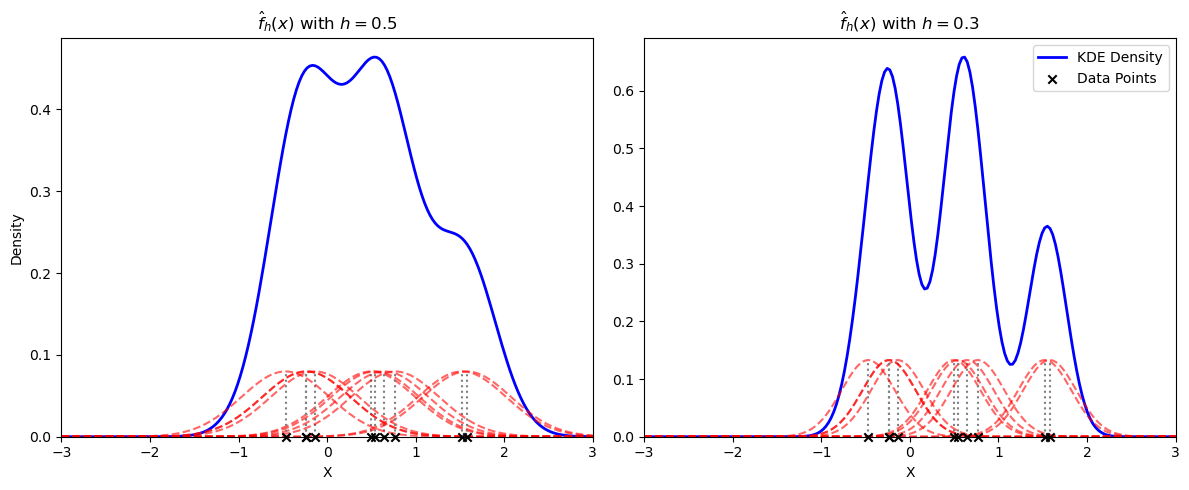

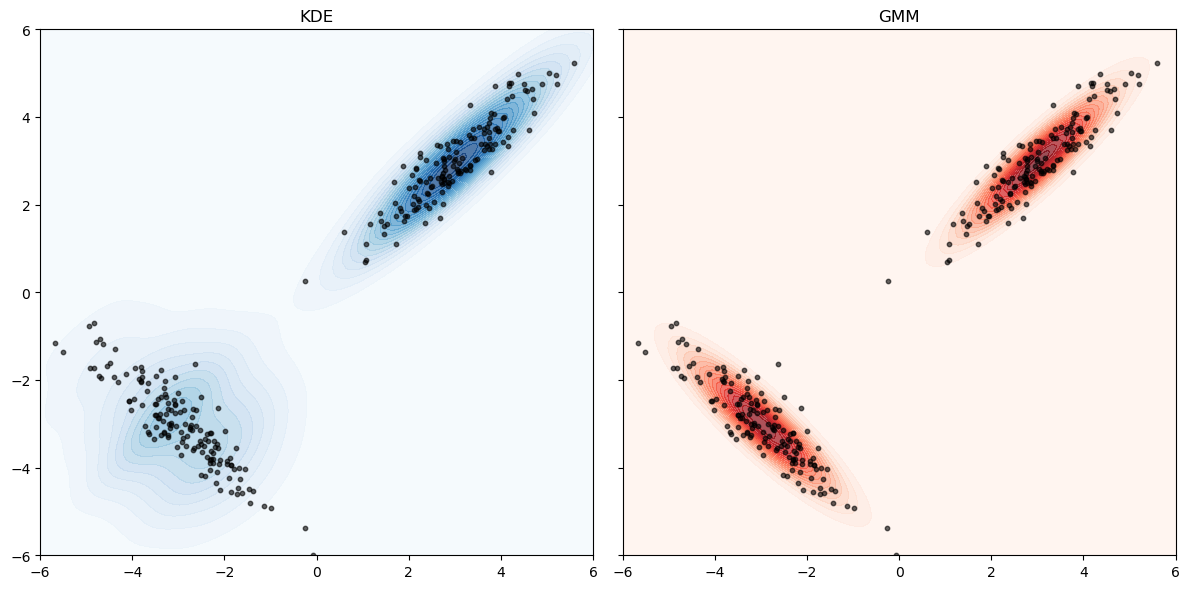

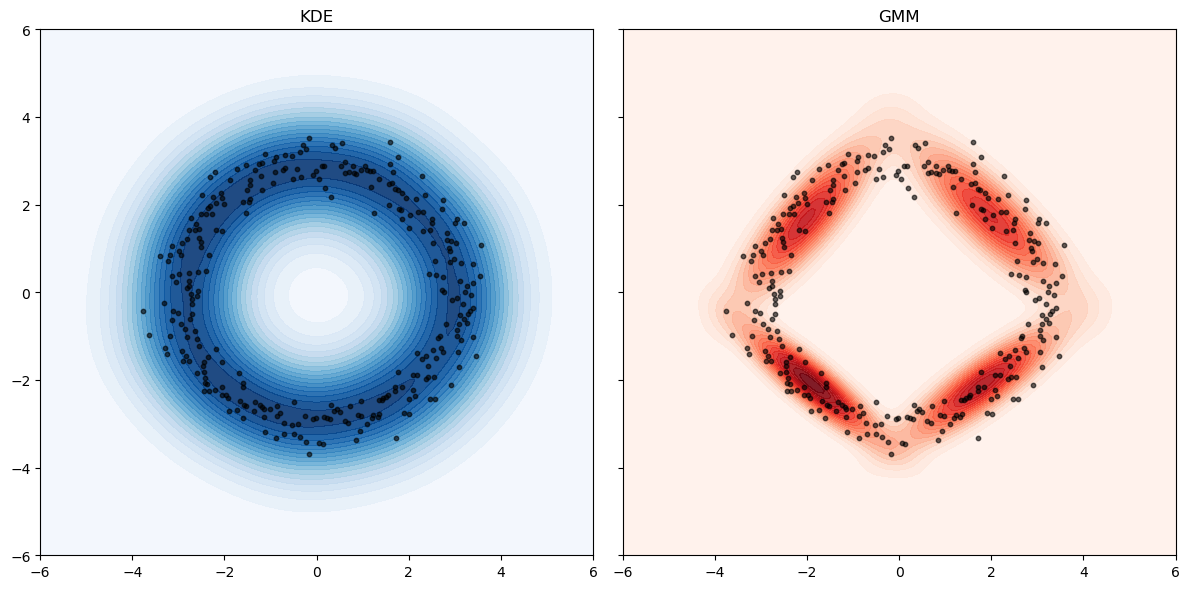

In [4]:
plot_sums()
plot_contours()

### Chapter 3

Plot saved to report/images/30_1.png


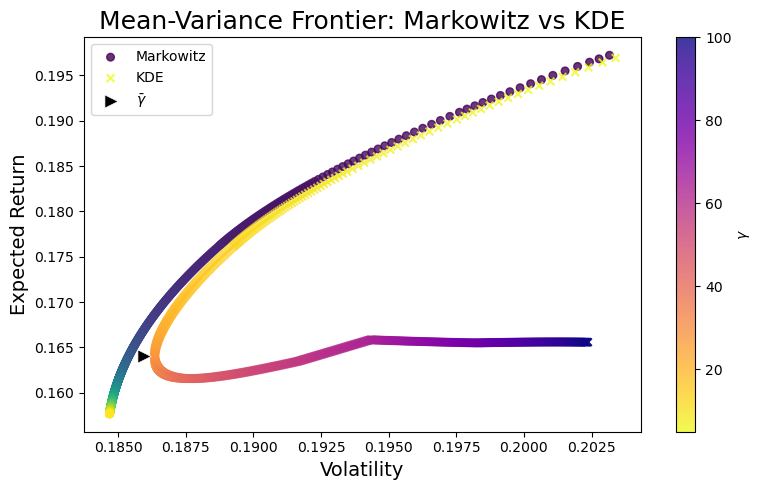

Plot saved to report/images/30_2.png


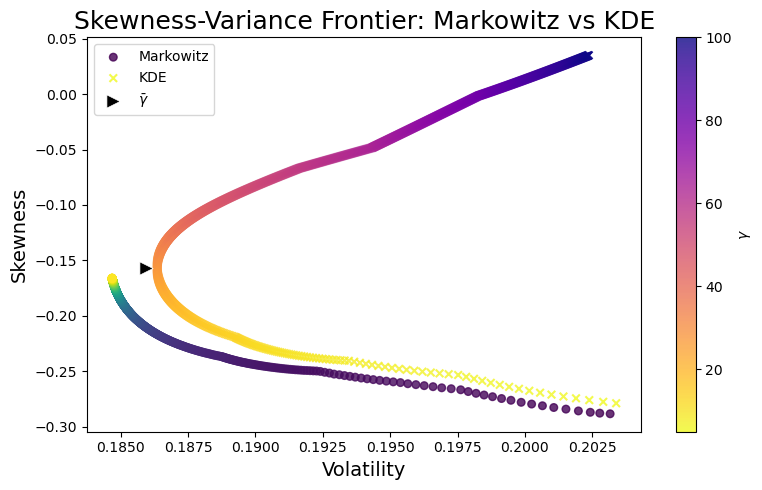

Min vol: 0.186350 with return: 0.164024
Gamma at minimum variance portfolio: 27.4424


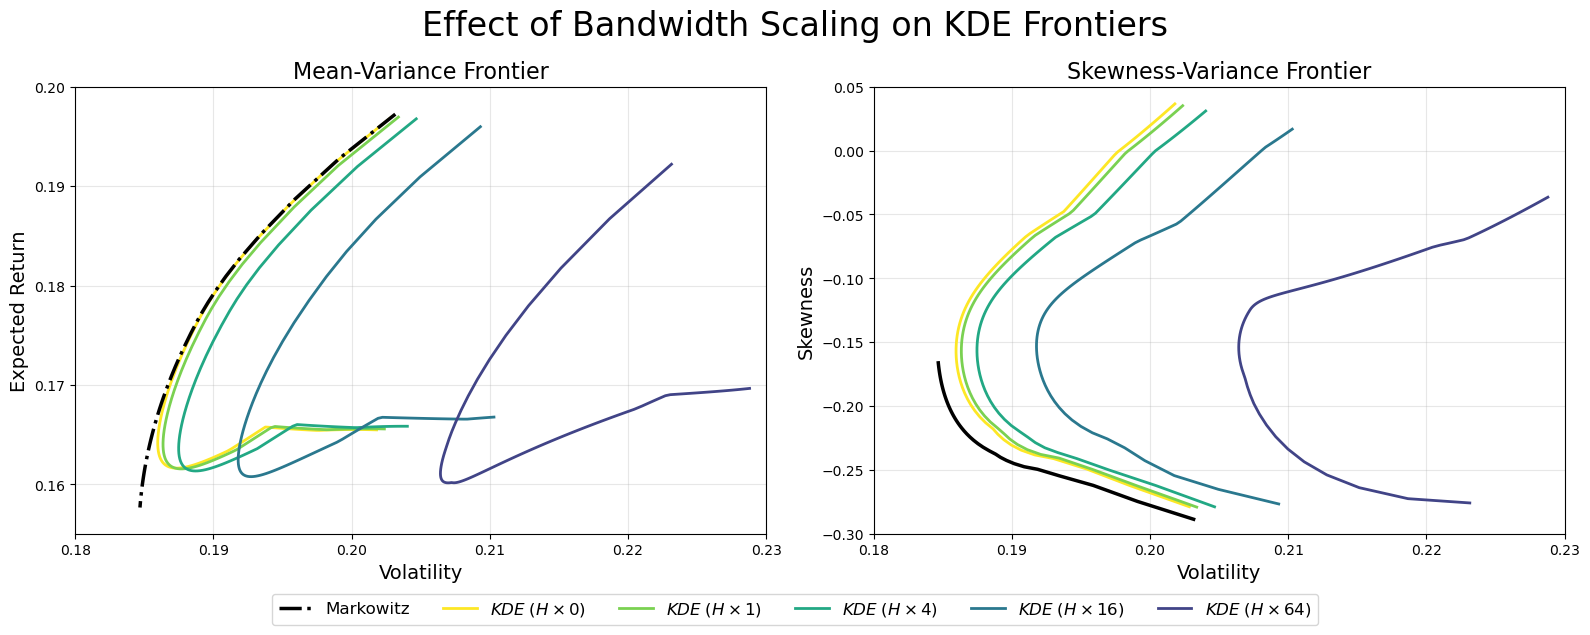

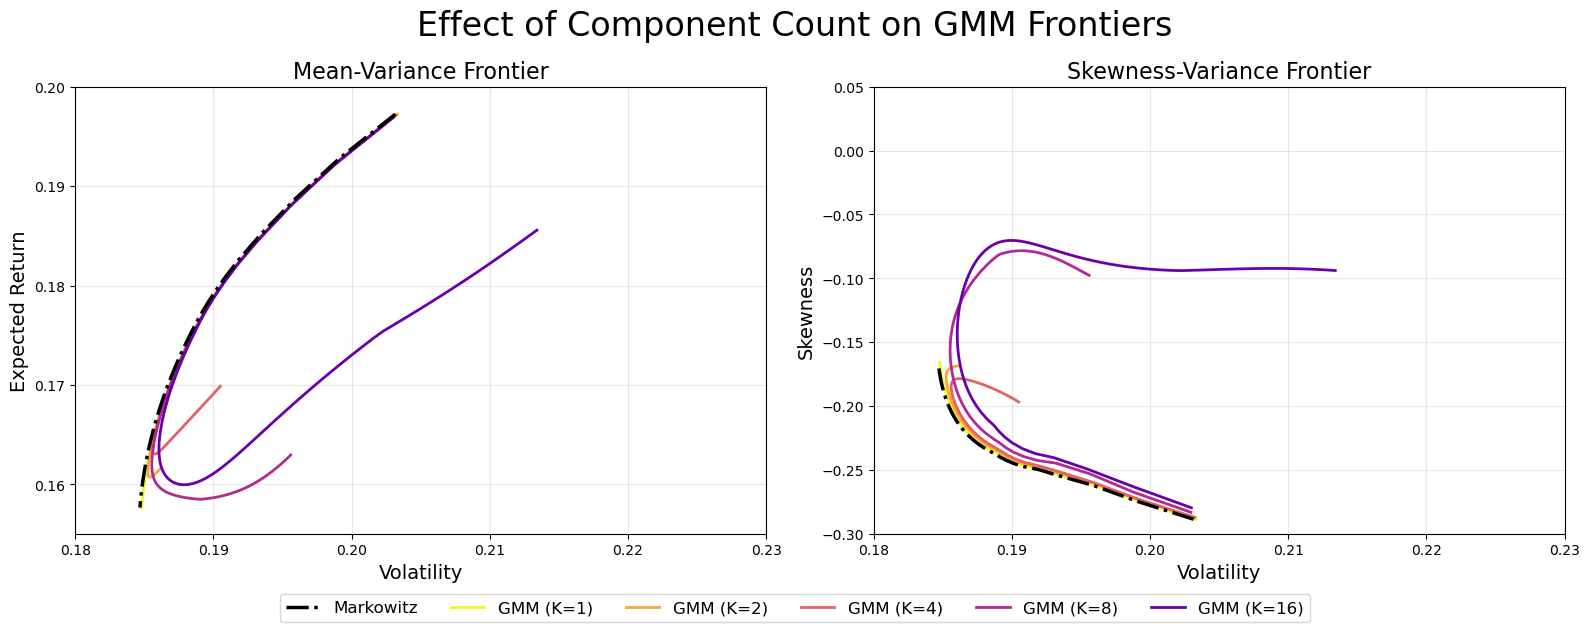

In [5]:
frontiers(best_returns)
kde_frontiers(best_returns)
gmm_frontiers(best_returns)

### Chapter 4+

Loaded 828 rows from 4 indices.
Number of configurations per index:
FTSE100: 194 configurations
HSI: 196 configurations
S&P500: 242 configurations
STOXX50: 196 configurations
Aggregated metrics:
                mu     std      SR      CR     VaR     MDD   |MDD|
value       0.0982  0.1814  0.4370  1.3317  0.2687  0.3534  3.0056
min_var     0.0849  0.1669  0.3895  1.0771  0.2423  0.3475  3.4809
max_sharpe  0.1885  0.1996  0.3817  1.2292  0.2950  0.3909  3.6075
markowitz   0.1922  0.2125  0.3645  1.2629  0.3143  0.4174  4.0214
Radar plot saved to report/images/40_1.png


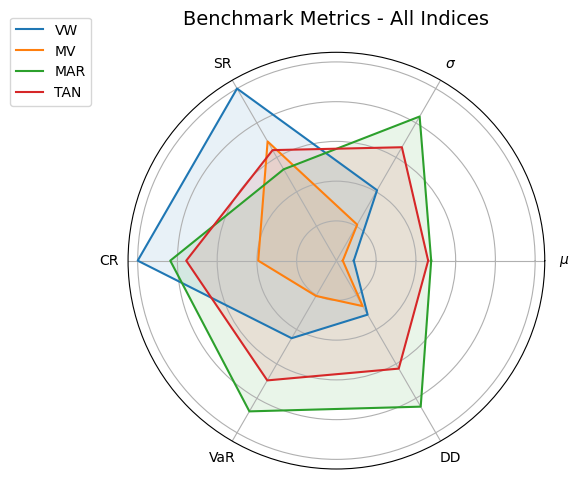

Dual radar plots saved to report/images/40_3.png


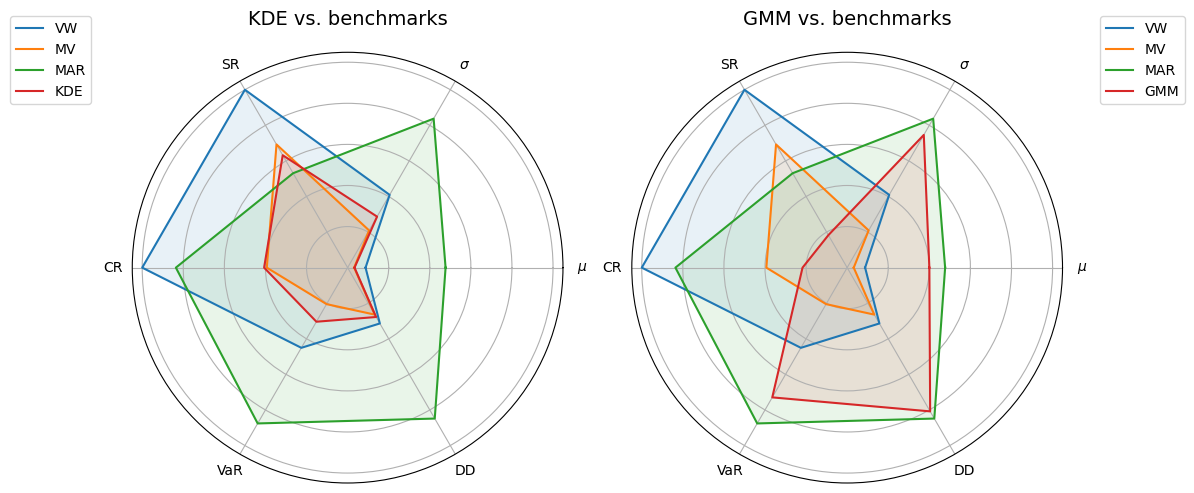

Dual radar plots saved to report/images/40_4.png


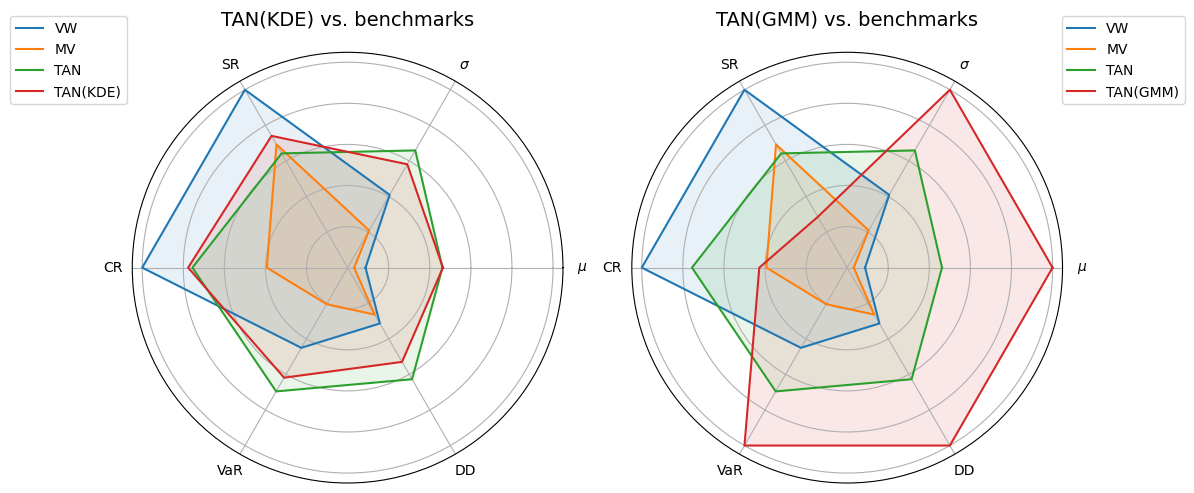

Radar plot saved to report/images/40_2.png


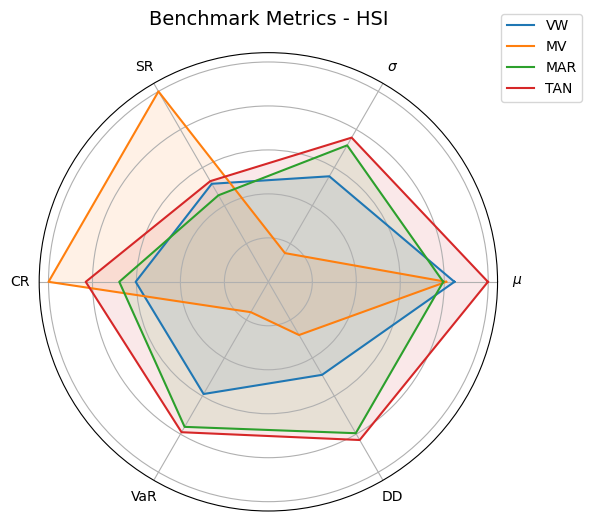

In [6]:
indices = ['FTSE100', 'HSI', 'S&P500', 'STOXX50']
metrics = ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|', 'ES', 'SR_pen']    
portfolios = ["equal", "min_var", "max_sharpe", "kde", "gmm", 
              "kde_max_sharpe", "gmm_max_sharpe", "value", "markowitz"]

dfs = []
for index in indices:
    file_path = f"data/processed_portfolio_returns/portfolio_metrics_{index}.csv"
    df = pd.read_csv(file_path)
    df["index"] = index
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df = df[df['window_density'] >= 0.1]
print(f"Loaded {len(df)} rows from {len(indices)} indices.")

print("Number of configurations per index:")
for index in indices:
    count = df[df['index'] == index].shape[0]
    print(f"{index}: {count} configurations")

window_order = ["1months", "3months", "6months", "1years", "3years", "5years", "10years"]
rebalancing_frequencies = ["monthly", "annual"]

df["window"] = pd.Categorical(df["window"], categories=window_order, ordered=True)
df["reb_freq"] = pd.Categorical(df["reb_freq"], categories=rebalancing_frequencies, ordered=True)
df["index"] = pd.Categorical(df["index"], categories=indices, ordered=True)

df[['MDD', 'MDD_duration', 'VaR', 'ES']] = df[['MDD', 'MDD_duration', 'VaR', 'ES']] * -1
for portfolio in portfolios:
    df[f"{portfolio}_MDD"] *= -1
    df[f"{portfolio}_VaR"] *= -1
    df[f"{portfolio}_ES"] *= -1
    
df.rename(columns={f"{portfolio}_MDD_duration": f"{portfolio}_|MDD|" for portfolio in portfolios}, inplace=True)

portfolio_metrics = [f"{portfolio}_{metric}" for portfolio in portfolios for metric in metrics]
grouped_df = df.groupby(["reb_freq", "window", "data_freq"], observed=True)[portfolio_metrics].mean().mean()

result_df = pd.DataFrame(index=portfolios, columns=metrics)
for portfolio in portfolios:
    for metric in metrics:
        key = f"{portfolio}_{metric}"
        result_df.at[portfolio, metric] = grouped_df[key]

result_df = result_df.apply(pd.to_numeric)
print('Aggregated metrics:')
out = result_df.loc[['value', 'min_var', 'markowitz', 'max_sharpe'], ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|']]
out1 = result_df.loc[['value', 'min_var', 'markowitz', 'kde', 'gmm'], ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|']]
out2 = result_df.loc[['value', 'min_var', 'max_sharpe', 'kde_max_sharpe', 'gmm_max_sharpe'], ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|']]
print(out.sort_values(by='SR', ascending=False).round(4))

latex_str = df_to_latex(out, filename="40_1.tex")
latex_str = df_to_latex(out1, filename="40_2.tex")
latex_str = df_to_latex(out2, filename="40_3.tex")

result_df['-VaR'] = result_df['VaR'] * -1
result_df['-MDD'] = result_df['MDD'] * -1
radar_df = result_df[['mu', 'std', 'SR', 'CR', 'VaR', 'MDD']]

f = 1.1
method = 'minmax'

def graphs0():
    keys = ['value', 'min_var', 'markowitz', 'max_sharpe']
    if indices == ['HSI']:
        name = 'Benchmark Metrics - HSI'
        radar(radar_df, keys=keys,  normalize=True, method=method, fudge=f, title=name, save_path='40_1.png', left=False)
    else:
        name = 'Benchmark Metrics - All Indices'
        radar(radar_df, keys=keys,  normalize=True, method=method, fudge=f, title=name, save_path='40_1.png', left=True)

def graphs1():
    base = ["value", "min_var", "markowitz",]
    left = base + ["kde"]
    right = base + ["gmm"]
    names = ['KDE vs. benchmarks', 'GMM vs. benchmarks']

    dual_radar(radar_df, left=left, right=right, normalize=True, method=method, fudge=f, title_left=names[0], title_right=names[1], save_path='40_3.png')

def graphs2():
    base = ["value", "min_var", "max_sharpe",]
    left = base + ["kde_max_sharpe"]
    right = base + ["gmm_max_sharpe"]
    names = ['TAN(KDE) vs. benchmarks', 'TAN(GMM) vs. benchmarks']

    dual_radar(radar_df, left=left, right=right, normalize=True, method=method, fudge=f, title_left=names[0], title_right=names[1], save_path='40_4.png')

def graphs3():
    keys_z = ['value', 'min_var', 'markowitz', 'max_sharpe']

    dfa = df[df['index'] == 'HSI'].copy()
    grouped_df = dfa.groupby(["reb_freq", "window", "data_freq"], observed=True)[portfolio_metrics].mean().mean()

    result_df_z = pd.DataFrame(index=portfolios, columns=metrics)
    for portfolio in portfolios:
        for metric in metrics:
            key = f"{portfolio}_{metric}"
            result_df_z.at[portfolio, metric] = grouped_df[key]

    result_df_z = result_df_z.apply(pd.to_numeric)
    result_df_z['-VaR'] = result_df_z['VaR'] * -1
    result_df_z['-MDD'] = result_df_z['MDD'] * -1
    radar_df_z = result_df_z[['mu', 'std', 'SR', 'CR', 'VaR', 'MDD']]
    name = 'Benchmark Metrics - HSI'
    radar(radar_df_z, keys=keys_z,  normalize=True, method=method, fudge=f, title=name, save_path='40_2.png')

graphs0() #Base portfolios
graphs1() #Base portfolios vs. KDE/GMM portfolios
graphs2() #Base portfolios vs. KDE/GMM max sharpe portfolios
graphs3() #VW, MV vs. KDE/GMM portfolios - single radar

In [7]:
results_by_index = {}
grouped = df.groupby(["index", "reb_freq", "window", "data_freq"], observed=True)[portfolio_metrics].mean()
for index in indices:
    index_group = grouped.loc[index]
    result_df = pd.DataFrame(index=portfolios, columns=metrics)
    for portfolio in portfolios:
        for metric in metrics:
            key = f"{portfolio}_{metric}"
            result_df.at[portfolio, metric] = index_group[key].mean()
    result_df = result_df.apply(pd.to_numeric)
    results_by_index[index] = result_df

latex_str = create_combined_index_table(results_by_index, indices, filename="A40_1.tex")
f = 1.1
method = 'minmax'
for posix, index in enumerate(indices):
    print(f'Aggregated metrics for {index}:')
    out = results_by_index[index].sort_values(by='SR', ascending=False).round(4)
    out = out[out.index != 'equal']
    base = ["value", "min_var",]
    left = base + ['kde', "kde_max_sharpe"]
    right = base + ['gmm', "gmm_max_sharpe"]
    names = ['KDE', 'GMM']
    radar_df = out[['mu', 'std', 'SR', 'CR', 'VaR', 'MDD']]
    out1 = out[['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|']]
    print(out1)

Aggregated metrics for FTSE100:
                    mu     std      SR      CR     VaR     MDD   |MDD|
value           0.0804  0.1584  0.3892  0.9427  0.2278  0.3301  2.5994
kde             0.0760  0.1638  0.3511  0.9171  0.2342  0.3297  3.4286
kde_max_sharpe  0.4548  0.1787  0.3399  0.8957  0.2558  0.3508  3.5877
min_var         0.0733  0.1596  0.3390  0.8599  0.2257  0.3342  3.4339
max_sharpe      0.4531  0.1841  0.3235  0.8745  0.2642  0.3620  3.8371
markowitz       0.4681  0.2028  0.3223  0.9785  0.2916  0.3951  4.1021
gmm             0.4395  0.2069  0.2915  0.8477  0.2858  0.4024  4.3971
gmm_max_sharpe  1.0399  0.2111  0.2863  0.7454  0.2990  0.4156  4.6076
Aggregated metrics for HSI:
                    mu     std      SR      CR     VaR     MDD   |MDD|
min_var         0.0581  0.1582  0.2419  0.6123  0.2454  0.3957  5.3408
kde             0.0543  0.1645  0.2060  0.5393  0.2571  0.4025  5.5658
kde_max_sharpe  0.0617  0.2119  0.1917  0.5613  0.3286  0.4952  4.8538
max_sharpe      0

In [8]:
metrics = ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|', 'ES', 'SR_pen']    
portfolios = ["equal", "min_var", "max_sharpe", "kde", "gmm", 
              "kde_max_sharpe", "gmm_max_sharpe", "value", "markowitz"]

portfolio_metrics = [f"{portfolio}_{metric}" for portfolio in portfolios for metric in metrics]
non_max_df = df.copy()

non_max_df = non_max_df[non_max_df['window_density'] >= 0.1]
grouped_df = non_max_df.groupby(["reb_freq", "window", "data_freq"], observed=True)[portfolio_metrics].mean()

print('Aggregated metrics for non-max portfolios:')
keys = [f'{portfolio}_SR_pen' for portfolio in ('kde_max_sharpe',)] + ['kde_max_sharpe_SR']

mini_portfolios = ['value', 'min_var', 'markowitz', 'max_sharpe', 'kde', 'gmm', 'kde_max_sharpe', 'gmm_max_sharpe']
cfg_info = ["reb_freq", "window", "data_freq",  "SR", "SR_pen",]
result_df = pd.DataFrame(index=mini_portfolios, columns=cfg_info)


idx_list = [portfolio + '_SR_pen' for portfolio in mini_portfolios]
index_grouped_df = df.groupby(["reb_freq", "window", "data_freq", "index", 'N'], observed=True)[idx_list].mean().reset_index()
index_grouped_df = index_grouped_df[index_grouped_df['N'] == 'max']
best_configs = {}

max_df = (df.query("N == 'max'").groupby(["reb_freq", "window", "data_freq", "index"], observed=True)[idx_list].mean().reset_index())
valid_counts = (max_df.groupby(["reb_freq","window","data_freq"], observed=True)["index"].nunique())
needed = len(indices)
valid_cfgs = valid_counts[valid_counts == needed].index

best_configs = {}
for portfolio in mini_portfolios:
    sr = grouped_df[portfolio + "_SR_pen"]
    sr_valid = sr.loc[valid_cfgs]
    best_configs[portfolio] = sr_valid.idxmax()

for portfolio, best_cfg in best_configs.items():
    reb, window, data_freq = best_cfg
    window_months = 0
    if isinstance(window, str):
        if window[1].isnumeric():
            size_part = window[:2]
            unit_part = window[2:]
        else:
            size_part = window[:1]
            unit_part = window[1:]
        
        size = int(size_part)
        if unit_part == "months":
            window_months = size
        elif unit_part == "years":
            window_months = size * 12
    
    result_df.at[portfolio, 'reb_freq'] = reb
    result_df.at[portfolio, 'window'] = window
    result_df.at[portfolio, 'data_freq'] = data_freq
    result_df.at[portfolio, 'SR_pen'] = grouped_df.loc[reb, window, data_freq][portfolio + '_SR_pen'].round(4)
    result_df.at[portfolio, 'SR'] = grouped_df.loc[reb, window, data_freq][portfolio + '_SR'].round(4)

print(result_df.sort_values(by='SR_pen', ascending=False))
latex_str = df_config_to_latex(result_df.sort_values(by='SR_pen', ascending=False), filename="40_4.tex")

df_plot = result_df.copy().sort_values(by='SR_pen', ascending=False)

Aggregated metrics for non-max portfolios:
               reb_freq   window data_freq      SR  SR_pen
value            annual   5years   monthly  0.4835  0.3788
min_var         monthly  3months     daily  0.5005  0.3773
kde             monthly  6months     daily  0.4714  0.3587
kde_max_sharpe  monthly   5years   monthly  0.4812  0.3467
markowitz        annual   1years     daily  0.4599  0.3251
max_sharpe      monthly   5years   monthly  0.4624  0.3094
gmm_max_sharpe   annual   5years   monthly  0.4071   0.233
gmm             monthly   1years    weekly  0.3627  0.1947


['value', 'min_var', 'kde', 'kde_max_sharpe']
data/portfolio_returns/FTSE100/monthly_annual_5_years_Nmax_seed0.csv
data/portfolio_returns/FTSE100/daily_monthly_3_months_Nmax_seed0.csv
data/portfolio_returns/FTSE100/daily_monthly_6_months_Nmax_seed0.csv
data/portfolio_returns/FTSE100/monthly_monthly_5_years_Nmax_seed0.csv
['value', 'min_var', 'gmm', 'gmm_max_sharpe']
data/portfolio_returns/FTSE100/monthly_annual_5_years_Nmax_seed0.csv
data/portfolio_returns/FTSE100/daily_monthly_3_months_Nmax_seed0.csv
data/portfolio_returns/FTSE100/weekly_monthly_1_years_Nmax_seed0.csv
data/portfolio_returns/FTSE100/monthly_annual_5_years_Nmax_seed0.csv
Radar plot saved to report/images/40_6.png


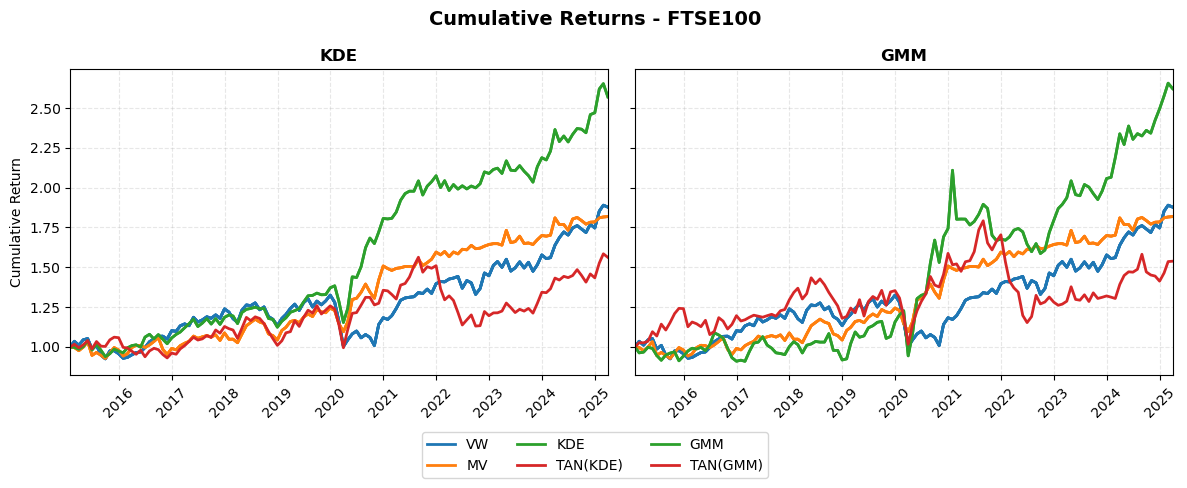

['value', 'min_var', 'kde', 'kde_max_sharpe']
data/portfolio_returns/HSI/monthly_annual_5_years_Nmax_seed0.csv
data/portfolio_returns/HSI/daily_monthly_3_months_Nmax_seed0.csv
data/portfolio_returns/HSI/daily_monthly_6_months_Nmax_seed0.csv
data/portfolio_returns/HSI/monthly_monthly_5_years_Nmax_seed0.csv
['value', 'min_var', 'gmm', 'gmm_max_sharpe']
data/portfolio_returns/HSI/monthly_annual_5_years_Nmax_seed0.csv
data/portfolio_returns/HSI/daily_monthly_3_months_Nmax_seed0.csv
data/portfolio_returns/HSI/weekly_monthly_1_years_Nmax_seed0.csv
data/portfolio_returns/HSI/monthly_annual_5_years_Nmax_seed0.csv
Radar plot saved to report/images/40_7.png


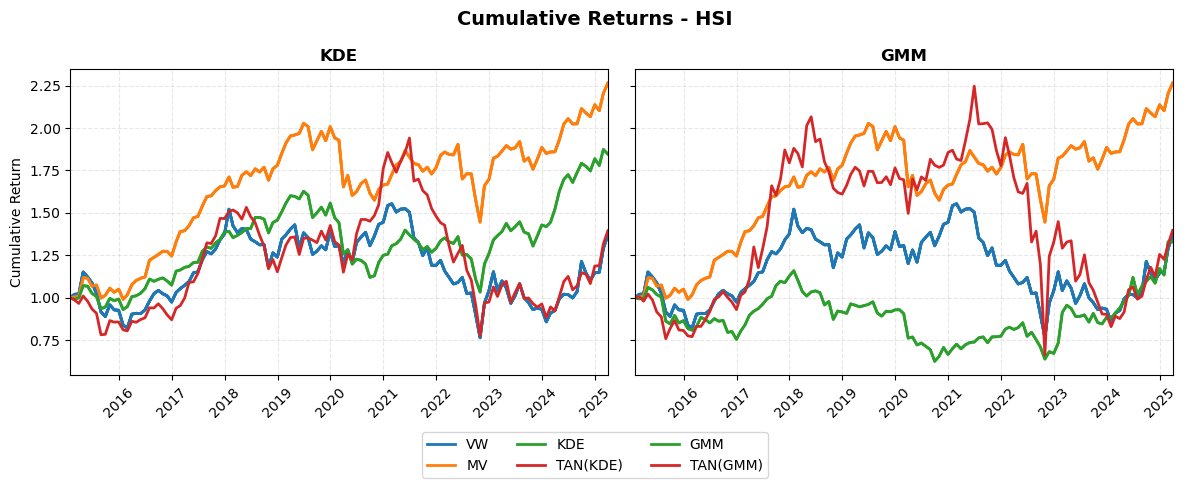

['value', 'min_var', 'kde', 'kde_max_sharpe']
data/portfolio_returns/S&P500/monthly_annual_5_years_Nmax_seed0.csv
data/portfolio_returns/S&P500/daily_monthly_3_months_Nmax_seed0.csv
data/portfolio_returns/S&P500/daily_monthly_6_months_Nmax_seed0.csv
data/portfolio_returns/S&P500/monthly_monthly_5_years_Nmax_seed0.csv
['value', 'min_var', 'gmm', 'gmm_max_sharpe']
data/portfolio_returns/S&P500/monthly_annual_5_years_Nmax_seed0.csv
data/portfolio_returns/S&P500/daily_monthly_3_months_Nmax_seed0.csv
data/portfolio_returns/S&P500/weekly_monthly_1_years_Nmax_seed0.csv
data/portfolio_returns/S&P500/monthly_annual_5_years_Nmax_seed0.csv
Radar plot saved to report/images/40_8.png


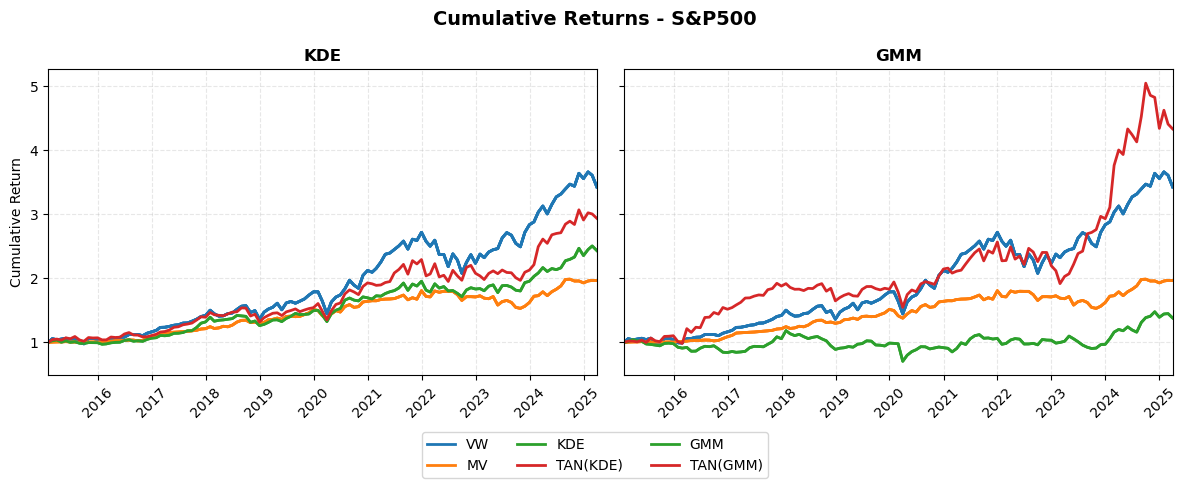

['value', 'min_var', 'kde', 'kde_max_sharpe']
data/portfolio_returns/STOXX50/monthly_annual_5_years_Nmax_seed0.csv
data/portfolio_returns/STOXX50/daily_monthly_3_months_Nmax_seed0.csv
data/portfolio_returns/STOXX50/daily_monthly_6_months_Nmax_seed0.csv
data/portfolio_returns/STOXX50/monthly_monthly_5_years_Nmax_seed0.csv
['value', 'min_var', 'gmm', 'gmm_max_sharpe']
data/portfolio_returns/STOXX50/monthly_annual_5_years_Nmax_seed0.csv
data/portfolio_returns/STOXX50/daily_monthly_3_months_Nmax_seed0.csv
data/portfolio_returns/STOXX50/weekly_monthly_1_years_Nmax_seed0.csv
data/portfolio_returns/STOXX50/monthly_annual_5_years_Nmax_seed0.csv
Radar plot saved to report/images/40_9.png


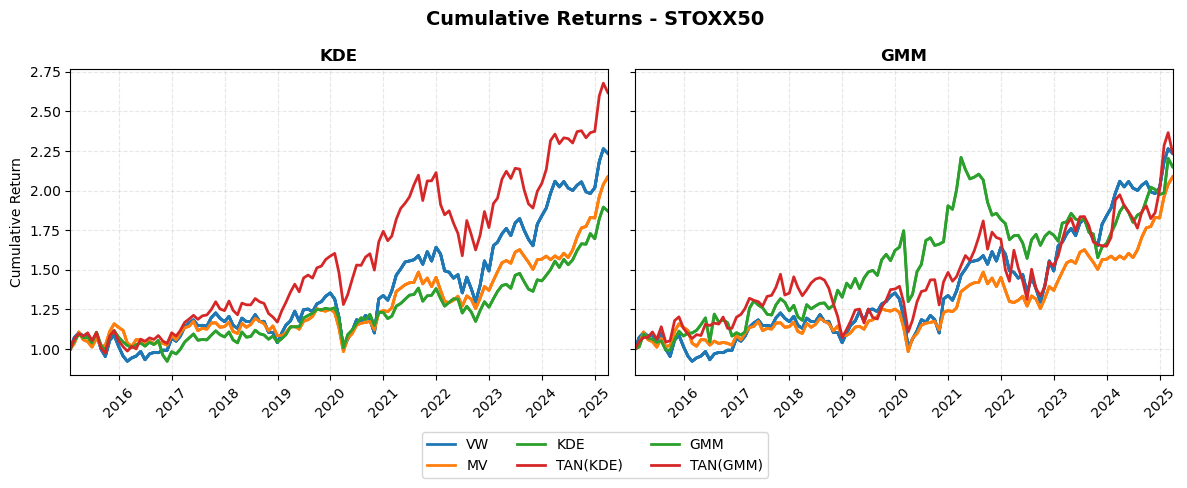

In [9]:
def plot(ax, df, include_ylabel=True):
    cumulative_returns = (1 + df).cumprod()
    cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]

    portfolio_map = {
        "value": "VW",
        "min_var": "MV",
        "markowitz": "MAR",
        "max_sharpe": "TAN",
        "kde": "KDE",
        "gmm": "GMM",
        "kde_max_sharpe": "TAN(KDE)",
        "gmm_max_sharpe": "TAN(GMM)",
    }

    palette = sns.color_palette("tab10", n_colors=len(df.columns))

    handles = []
    labels = []

    for col, color in zip(df.columns, palette):
        display_name = portfolio_map.get(col, col)
        handle, = ax.plot(cumulative_returns.index, cumulative_returns[col], label=display_name, linewidth=2, color=color)
        handles.append(handle)
        labels.append(display_name)

    if include_ylabel:
        ax.set_ylabel("Cumulative Return", fontsize=10)
    
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlim(cumulative_returns.index[0], cumulative_returns.index[-1])
    ax.tick_params(axis='x', rotation=45)

    return handles, labels

def plot_best(p1, p2, save_path=None):
    
    for index in indices:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
        axes = axes.flatten()
        titles = ['KDE', 'GMM']

        match index:
            case 'FTSE100':
                n = 6
            case 'HSI':
                n = 7
            case 'S&P500':
                n = 8
            case 'STOXX50':
                n = 9

        all_handles = []
        all_labels = []

        for j, p in enumerate([p1, p2]):
            print(p)
            include_ylabel = (j == 0)
            
            best_portfolios = []
            for row in result_df.iterrows():
                portfolio = row[0]
                if portfolio not in p:
                    continue
                reb_freq = row[1]['reb_freq']
                window_str = row[1]['window']
                data_freq = row[1]['data_freq']

                if window_str[1].isnumeric():
                    window_size = window_str[:2]
                    window_unit = window_str[2:]
                else:
                    window_size = window_str[0]
                    window_unit = window_str[1:]

                config = f"{data_freq}_{reb_freq}_{window_size}_{window_unit}_Nmax_seed0"
                file_path = f"data/portfolio_returns/{index}/{config}.csv"
                print(file_path)
                temp_df = pd.read_csv(file_path, index_col=["DATE"], parse_dates=True)
                if data_freq == "daily":
                    temp_df = temp_df.resample('ME').apply(lambda x: (x + 1).prod() - 1)
                elif data_freq == "weekly":
                    temp_df = temp_df.resample('ME').apply(lambda x: (x + 1).prod() - 1)
                mask = temp_df.isna().all(axis=1) | (temp_df == 0).all(axis=1)
                temp_df = temp_df[~mask][portfolio]
                temp_df = temp_df[temp_df.index.year >= 2015]
                best_portfolios.append(temp_df)

                best_df = pd.concat(best_portfolios, axis=1)
                handles, labels = plot(axes[j], best_df, include_ylabel=include_ylabel)
                all_handles += handles
                all_labels += labels

            axes[j].set_title(titles[j], fontsize=12, fontweight='bold')

        fig.suptitle(f"Cumulative Returns - {index}", fontsize=14, fontweight='bold', y=0.9)

        by_label = dict(zip(all_labels, all_handles))
        
        desired_order = [
            'VW', 'MV', 'TAN', 'KDE',
            'TAN(KDE)', 'GMM', 'TAN(GMM)'
        ]
        
        ordered_labels = [label for label in desired_order if label in by_label]
        ordered_handles = [by_label[label] for label in ordered_labels]

        fig.legend(
            ordered_handles,
            ordered_labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.05),
            ncol=3,
            fontsize=10
        )

        plt.tight_layout(rect=[0, 0.05, 1, 0.92])
        if save_path:
            img_path = f'report/images/{save_path}_{n}.png'
            plt.savefig(img_path, dpi=300, bbox_inches='tight')
            print(f"Radar plot saved to {img_path}")
        plt.show()

p1 = ['value', 'min_var', 'kde', 'kde_max_sharpe' ]
p2 = ['value', 'min_var', 'gmm', 'gmm_max_sharpe' ]
plot_best(p1, p2, save_path='40')

In [69]:
local_metrics = ['mu', 'std', 'CR', 'SR', 'VaR', 'MDD']    
local_metrics = ['mu', 'std', 'CR', 'SR', 'VaR', 'MDD', '|MDD|']    
portfolios = ["equal", "min_var", "max_sharpe", "kde", "gmm", 
              "kde_max_sharpe", "gmm_max_sharpe", "value", "markowitz"]

portfolio_metrics = [f"{portfolio}_{metric}" for portfolio in portfolios for metric in metrics]
non_max_df = df.copy()

non_max_df = non_max_df[non_max_df['N'] != 'BOOM']
grouped_df = non_max_df.groupby(["reb_freq", "window", "data_freq"], observed=True)[portfolio_metrics].mean()
index_grouped_df = df.groupby(["reb_freq", "window", "data_freq", "index", 'N'], observed=True)[portfolio_metrics].mean()

print('Aggregated metrics for non-max portfolios:')
keys = [f'{portfolio}_SR_pen' for portfolio in ('kde_max_sharpe',)] + ['kde_max_sharpe_SR']

mini_portfolios = ['value', 'min_var', 'markowitz', 'max_sharpe', 'kde', 'gmm', 'kde_max_sharpe', 'gmm_max_sharpe']
cfg_info = ["reb_freq", "window", "data_freq",  "SR", "SR_pen",]
per_index_metrics = pd.DataFrame(index=mini_portfolios, columns=cfg_info)

per_index_metrics_dict = {}

for index in indices:
    temp_group = index_grouped_df.reset_index()
    temp_group = temp_group[(temp_group['index'] == index) & (temp_group['N'] == 'max')].set_index(['reb_freq', 'window', 'data_freq'])
    per_index_metrics = pd.DataFrame(index=mini_portfolios, columns=local_metrics)
    for portfolio, config in best_configs.items():
        reb, window, data_freq = config
        for metric in local_metrics:
            val = temp_group.at[(reb, window, data_freq), f"{portfolio}_{metric}"]
            per_index_metrics.at[portfolio, metric] = round(val, 4)

    per_index_metrics_dict[index] = per_index_metrics

for index, metric_df in per_index_metrics_dict.items():
    print(f'\nAggregated metrics for {index} - (Full Index Investment):')
    print(metric_df.round(4))
    match index:
        case 'FTSE100':
            n = 5
        case 'HSI':
            n = 6
        case 'S&P500':
            n = 7
        case 'STOXX50':
            n = 8
    latex_str = df_to_latex(metric_df, filename=f"40_{n}.tex")
 

Aggregated metrics for non-max portfolios:

Aggregated metrics for FTSE100 - (Full Index Investment):
                    mu     std      CR      SR     VaR     MDD   |MDD|
value           0.0736  0.1199  0.9246  0.4455  0.1675  0.2439  1.5833
min_var         0.0675  0.1101  0.8185  0.4371  0.1673  0.1914  1.2077
markowitz       0.0768  0.2199   0.653  0.2602   0.335  0.5552  6.1615
max_sharpe      0.0379  0.1404  0.3231  0.1197  0.1921  0.3003  3.5833
kde              0.107  0.1265  1.5705  0.6865  0.1829  0.2826  1.2385
gmm             0.1171  0.1804  1.6224  0.5432   0.238  0.3034  2.9423
kde_max_sharpe  0.0578  0.1335  0.6241  0.2761   0.202  0.2767  3.4167
gmm_max_sharpe  0.0624  0.1648  0.6189  0.2339  0.2734  0.3568  3.5833

Aggregated metrics for HSI - (Full Index Investment):
                    mu     std      CR      SR     VaR     MDD   |MDD|
value           0.0593  0.2141  0.4375  0.1391  0.3292   0.508  4.0833
min_var         0.0952   0.134  1.2643  0.5613  0.2014  0.3036

In [70]:
metrics = ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|', 'ES', 'SR_pen']    
portfolios = ["equal", "min_var", "max_sharpe", "kde", "gmm", 
              "kde_max_sharpe", "gmm_max_sharpe", "value", "markowitz"]

portfolio_metrics = ['window_density', *[f"{portfolio}_{metric}" for portfolio in portfolios for metric in metrics]]
non_max_df = df.copy()

if 'N' in non_max_df.columns:
    non_max_df = non_max_df[non_max_df['N'] != 'max']
    grouped_df = non_max_df.groupby(["index", "reb_freq", "window", "data_freq", "N"], observed=True)[portfolio_metrics].mean()
else:
    print("Column 'N' not found in DataFrame. Checkdata structure.")

print('Aggregated metrics for non-max portfolios:')
keys = [f'{portfolio}_SR_pen' for portfolio in ('kde_max_sharpe',)] + ['kde_max_sharpe_SR']

mini_portfolios = ['value', 'min_var', 'markowitz', 'max_sharpe', 'kde', 'gmm', 'kde_max_sharpe', 'gmm_max_sharpe']
cfg_info = ["index", "reb_freq", "window", "data_freq", "N", "CR", "SR", "SR_pen", "dispersion"]
result_df = pd.DataFrame(index=mini_portfolios, columns=cfg_info)

per_index_config_dict = {}
index_returns_dict = {}
for index in indices:
    result_df = pd.DataFrame(index=mini_portfolios, columns=cfg_info)
    portfolio_returns_dfs = []
    
    for portfolio in mini_portfolios:
        sorted_df = grouped_df.sort_values(by=[f"{portfolio}_SR_pen"], ascending=False)
        temp_grouped_df = sorted_df[sorted_df.index.get_level_values('index') == index]
        temp_grouped_df = temp_grouped_df[temp_grouped_df['window_density'] >= 0.1]
        
        if not temp_grouped_df.empty:
            best_cfg = temp_grouped_df.iloc[0]
            idx = temp_grouped_df.index[0]
            
            idx_name, reb, window, data_freq, N = idx
            cr = temp_grouped_df.loc[idx][f"{portfolio}_CR"]
            sr = temp_grouped_df.loc[idx][f"{portfolio}_SR"]
            sr_pen = temp_grouped_df.loc[idx][f"{portfolio}_SR_pen"]
            
            result_df.loc[portfolio] = [idx_name, reb, window, data_freq, N, np.nan, sr, sr_pen, np.nan]
            
            config = f"{data_freq}_{reb}_{window}_{N}"
            file_path = f"data/median_returns_with_envelope/{index}/envelope_{config}.csv"
            
            try:
                iter_keys = [f"{portfolio}{alias}" for alias in ('_median', '_min', '_max')]
                temp_df = pd.read_csv(file_path, index_col=["DATE"], parse_dates=True)[iter_keys]
                
                if data_freq == "daily" or data_freq == "weekly":
                    temp_df = temp_df.resample('ME').apply(lambda x: (x + 1).prod() - 1)
                
                mask = temp_df.isna().all(axis=1) | (temp_df == 0).all(axis=1)
                temp_df = temp_df[~mask]
                temp_df = temp_df[temp_df.index.year >= 2015]
                
                temp_df.columns = [f"{portfolio}_median", f"{portfolio}_min", f"{portfolio}_max"]
                
                temp_df = temp_df.bfill()
                temp_df = (1 + temp_df).cumprod()
                
                last = temp_df.iloc[-1]
                dispersion = last[f"{portfolio}_max"] - last[f"{portfolio}_min"]
                result_df.loc[portfolio, 'CR'] = last[f"{portfolio}_median"]
                result_df.loc[portfolio, 'dispersion'] = dispersion

                portfolio_returns_dfs.append(temp_df)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
    
    per_index_config_dict[index] = result_df.copy()
    
    if portfolio_returns_dfs:
        combined_returns = portfolio_returns_dfs[0]
        for iter_df in portfolio_returns_dfs[1:]:
            combined_returns = combined_returns.join(iter_df, how='outer')
        
        index_returns_dict[index] = combined_returns

for index, metric_df in per_index_config_dict.items():
    print(f'\nOptimal configuration for {index}:')
    print(metric_df.drop(columns='index').round(4))


Aggregated metrics for non-max portfolios:

Optimal configuration for FTSE100:
               reb_freq   window data_freq   N        CR        SR    SR_pen  \
value           monthly   3years   monthly  30  1.995558  0.462657  0.399825   
min_var          annual   3years   monthly  30  2.094559  0.469579  0.367718   
markowitz        annual  6months    weekly  30  2.694712  0.528131  0.348616   
max_sharpe       annual  10years   monthly  30  2.189403   0.47347   0.33245   
kde              annual   3years   monthly  30  2.381211  0.594002  0.433575   
gmm              annual  6months   monthly  30  2.236909  0.495334  0.298198   
kde_max_sharpe   annual  3months    weekly  30  2.328276  0.486285   0.36362   
gmm_max_sharpe   annual  3months    weekly  30  2.247851  0.447059  0.292216   

               dispersion  
value            0.456281  
min_var           0.91882  
markowitz        2.663834  
max_sharpe       1.314545  
kde              1.456421  
gmm              2.449966  
kde_

Plot saved to report/images/40_10.png


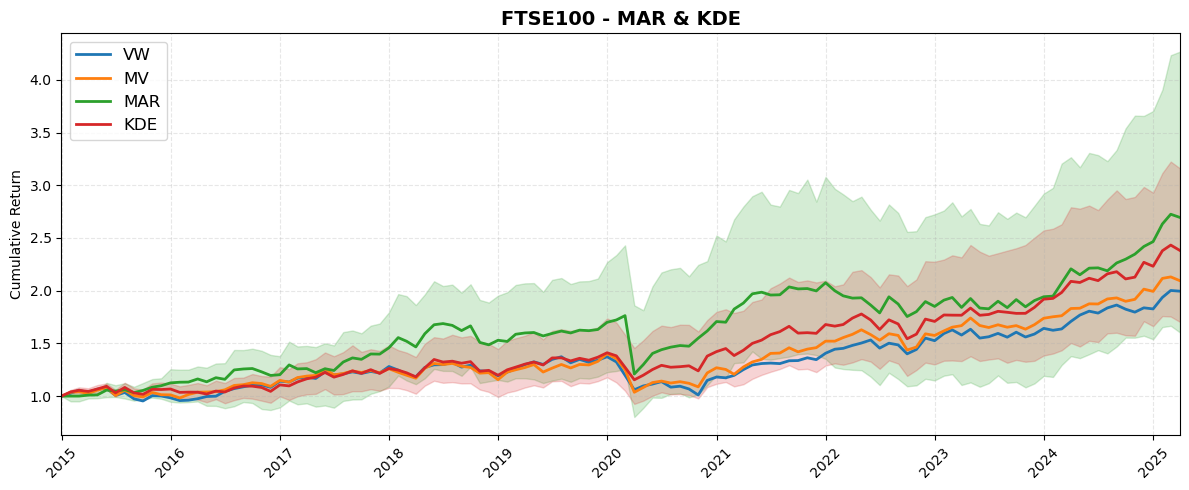

Created plot for FTSE100
Plot saved to report/images/40_11.png


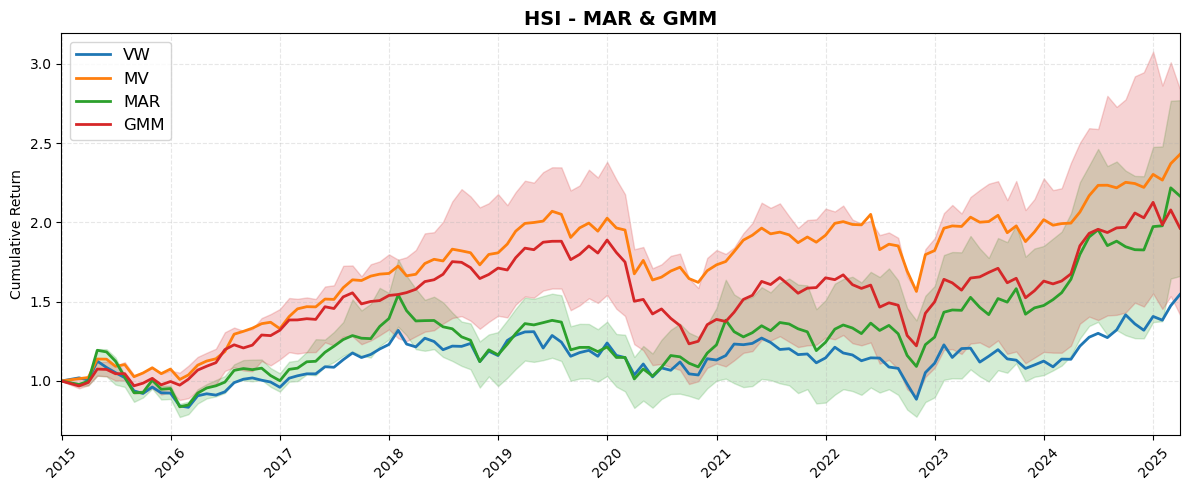

Created plot for HSI
Plot saved to report/images/40_12.png


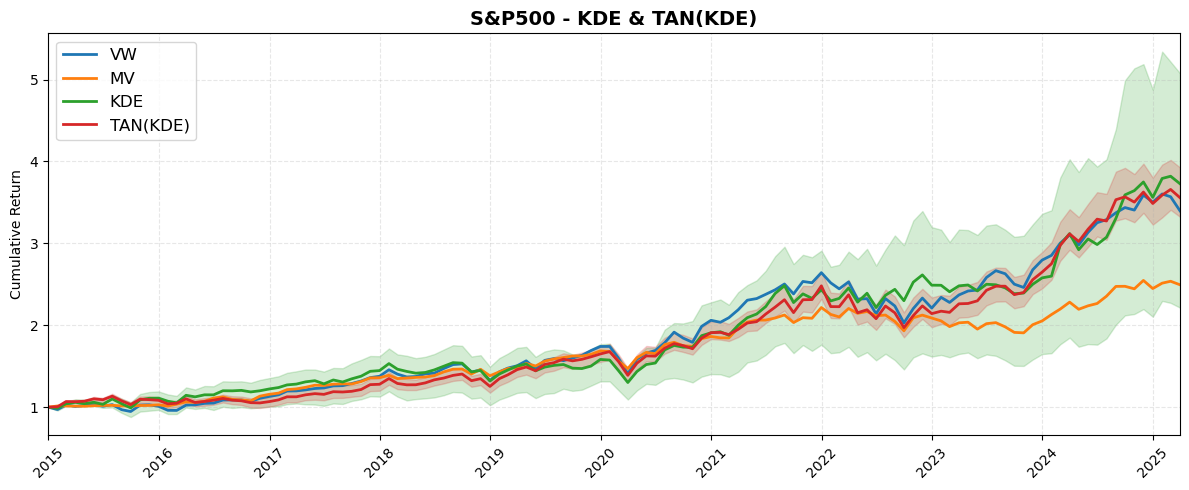

Created plot for S&P500


In [71]:


plot_configs = {
    'FTSE100': {
        'title_suffix': 'KDE & MAR Portfolio Configurations',
        'median_only': ["value", "min_var"],
        'with_envelope': ["markowitz", "kde"],
        'save_path': "40_10.png"
    },
    'HSI': {
        'title_suffix': 'GMM & MAR Portfolio Configurations',
        'median_only': ["value", "min_var"],
        'with_envelope': ["markowitz", "gmm"],
        'save_path': "40_11.png"
    },
    'S&P500': {
        'title_suffix': 'TAN(KDE) & TAN Portfolio Configurations',
        'median_only': ["value", "min_var"],
        'with_envelope': ["kde", "kde_max_sharpe"],
        'save_path': "40_12.png"
    }
}

portfolio_map = {
    "value": "VW",
    "min_var": "MV",
    "markowitz": "MAR",
    "max_sharpe": "TAN",
    "kde": "KDE",
    "gmm": "GMM",
    "kde_max_sharpe": "TAN(KDE)",
    "gmm_max_sharpe": "TAN(GMM)",
}

for index, config in plot_configs.items():
    if index in index_returns_dict:
        returns_df = index_returns_dict[index]
        
        envelope_names = [portfolio_map[p] for p in config['with_envelope']]
        title = f"{index} - {' & '.join(envelope_names)}"
        
        plot_cumulative_envelope(
            returns_df=returns_df.bfill(),
            median_only=config['median_only'],
            with_envelope=config['with_envelope'],
            title=title,
            save_path=config['save_path']
        )
        print(f"Created plot for {index}")
    else:
        print(f"Warning: {index} not found in available data")


Plot saved to report/images/40_14.png


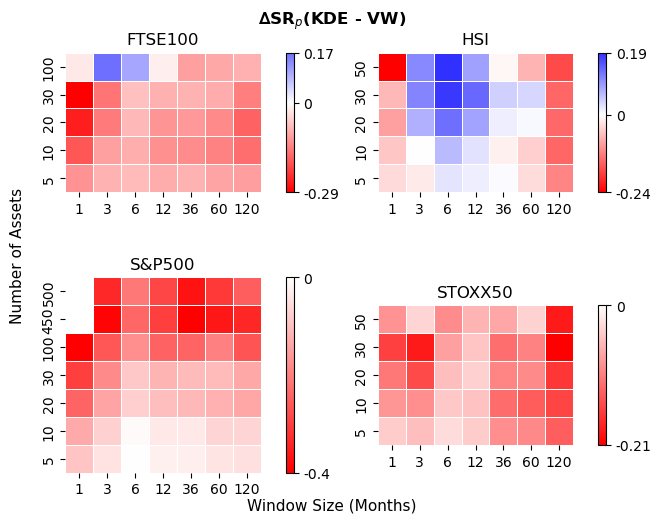

Plot saved to report/images/40_15.png


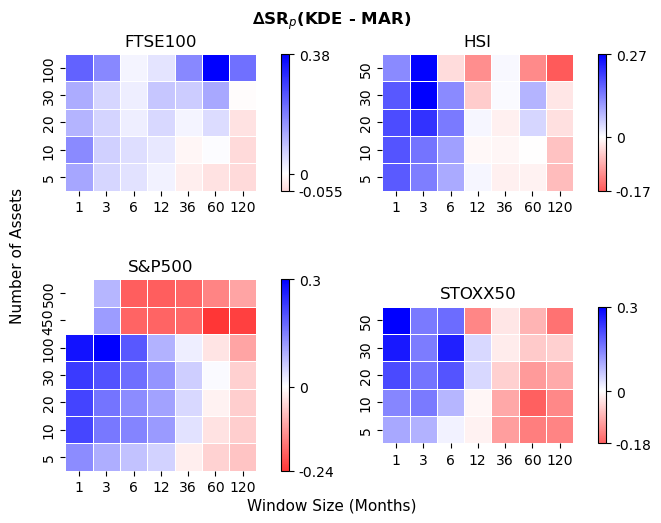

Plot saved to report/images/40_17.png


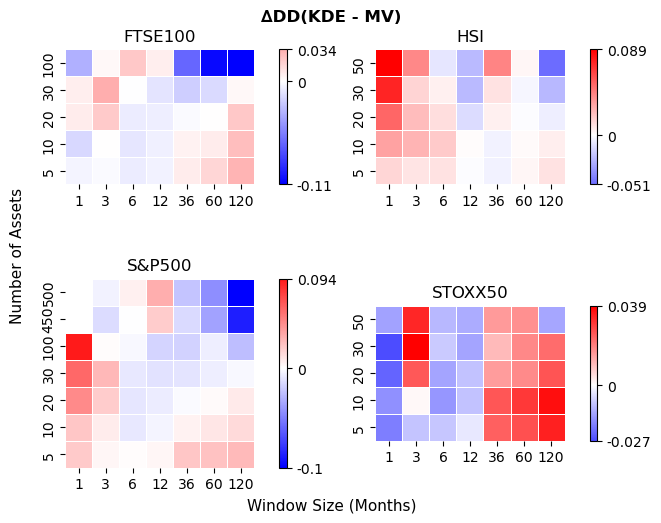

Plot saved to report/images/40_16.png


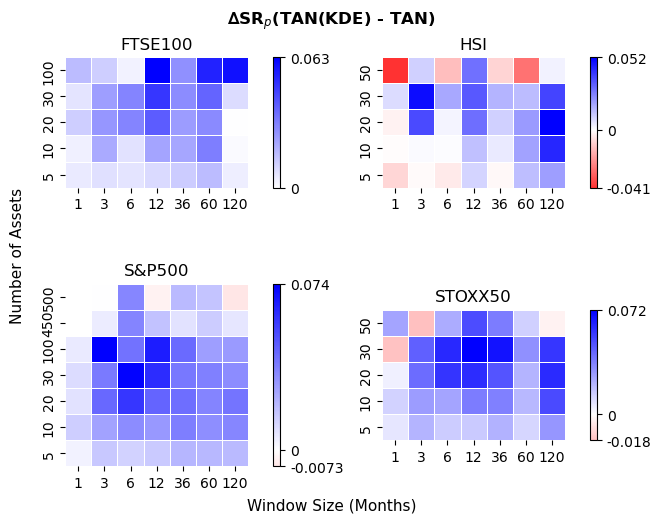

In [72]:
stable_df = df[df['window_density'] >= 0.1]
stable_df["window"] = stable_df["window"].apply(months_from_window)
stable_df['window_reb'] = (
    stable_df['window'].astype(str) 
    + "_" 
    + stable_df['reb_freq'].astype(str)
)

win_cats = list(stable_df['window'].cat.categories)
reb_cats = list(stable_df['reb_freq'].cat.categories)

combo_cats = [f"{w}_{r}" for w in win_cats for r in reb_cats]

stable_df['window_reb'] = pd.Categorical(
    stable_df['window_reb'],
    categories=combo_cats,
    ordered=True
)

res_dict = {}
base = 'kde'
delta = 'value'
metric = 'SR_pen'
name = f"{base}_vs_{delta}"
cmap = 'bwr_r'

stable_df[name] = stable_df[f"{base}_{metric}"] - stable_df[f"{delta}_{metric}"]
stable_df = stable_df.dropna(subset=[name])
stable_df = stable_df[stable_df[name].abs() < 1]
plot_heatmaps(name, stable_df, f'∆{metric}({base} - {delta})', cmap, save_path='40_14.png')

temp_res = heatmap_stats(stable_df, name, metric)
res_dict[f'{metric}({name})'] = temp_res

base = 'kde_max_sharpe'
delta = 'value'
metric = 'SR_pen'
name = f"{base}_vs_{delta}"
cmap = 'bwr_r'

stable_df[name] = stable_df[f"{base}_{metric}"] - stable_df[f"{delta}_{metric}"]
stable_df = stable_df.dropna(subset=[name])
stable_df = stable_df[stable_df[name].abs() < 1]

temp_res = heatmap_stats(stable_df, name, metric)
res_dict[f'{metric}({name})'] = temp_res

base = 'kde'
delta = 'markowitz'
metric = 'SR_pen'
name = f"{base}_vs_{delta}"
cmap = 'bwr_r'

stable_df[name] = stable_df[f"{base}_{metric}"] - stable_df[f"{delta}_{metric}"]
stable_df = stable_df.dropna(subset=[name])
stable_df = stable_df[stable_df[name].abs() < 1]
plot_heatmaps(name, stable_df, f'∆{metric}({base} - {delta})', cmap, save_path='40_15.png')

temp_res = heatmap_stats(stable_df, name, metric)
res_dict[f'{metric}({name})'] = temp_res

base = 'kde'
delta = 'min_var'
metric = 'MDD'
name = f"{base}_vs_{delta}"
cmap = 'bwr'

stable_df[name] = stable_df[f"{base}_{metric}"] - stable_df[f"{delta}_{metric}"]
stable_df = stable_df.dropna(subset=[name])
stable_df = stable_df[stable_df[name].abs() < 1]
plot_heatmaps(name, stable_df, f'∆{metric}({base} - {delta})', cmap, save_path='40_17.png')

temp_res = heatmap_stats(stable_df, name, metric)
res_dict[f'{metric}({name})'] = temp_res

base = 'kde_max_sharpe'
delta = 'min_var'
metric = 'MDD'
name = f"{base}_vs_{delta}"
cmap = 'bwr'

stable_df[name] = stable_df[f"{base}_{metric}"] - stable_df[f"{delta}_{metric}"]
stable_df = stable_df.dropna(subset=[name])
stable_df = stable_df[stable_df[name].abs() < 1]

temp_res = heatmap_stats(stable_df, name, metric)
res_dict[f'{metric}({name})'] = temp_res

base = 'kde_max_sharpe'
delta = 'max_sharpe'
metric = 'SR_pen'
name = f"{base}_vs_{delta}"
cmap = 'bwr_r'

stable_df[name] = stable_df[f"{base}_{metric}"] - stable_df[f"{delta}_{metric}"]
stable_df = stable_df.dropna(subset=[name])
stable_df = stable_df[stable_df[name].abs() < 1]
plot_heatmaps(name, stable_df, f'∆{metric}({base} - {delta})', cmap, save_path='40_16.png')

temp_res = heatmap_stats(stable_df, name, metric)
res_dict[f'{metric}({name})'] = temp_res

all_res_df = pd.DataFrame.from_dict(res_dict, orient='columns')


In [73]:
def tree(base, delta, metric):
    stable_df = df.loc[df['window_density'] >= 0.1].copy()
    stable_df["window"] = stable_df["window"].apply(months_from_window)

    name = f"{base}_vs_{delta}"

    stable_df[name] = stable_df[f"{base}_{metric}"] - stable_df[f"{delta}_{metric}"]
    stable_df = stable_df.dropna(subset=[name])
    stable_df = stable_df[stable_df[name].abs() < 1]

    diff_df = stable_df.copy()
    if metric in ['MDD', 'VaR', 'ES', 'std']:
        diff_df[name] = -diff_df[name]
    diff_df['above_zero'] = (diff_df[name] > 0).astype(int)

    diff_df['data_freq'] = pd.Categorical(
        diff_df['data_freq'],
        categories=['daily', 'weekly', 'monthly'],
        ordered=True
    )

    ordinal_features = ['data_freq', 'window']
    nominal_features = ['index']
    numeric_features = ['N_int']

    ordinal_categories = [
        diff_df[f].cat.categories.tolist()
        for f in ordinal_features
    ]

    preprocessor = ColumnTransformer([
        ('ord', OrdinalEncoder(dtype=int, categories=ordinal_categories),
            ordinal_features),
        ('nom', OneHotEncoder(sparse_output=False, dtype=int), nominal_features),
        ('num', 'passthrough', numeric_features),
    ])

    pipe = Pipeline([
        ('preproc', preprocessor),
        ('clf', DecisionTreeClassifier(
            max_depth=4,
            min_samples_leaf=25,
            class_weight='balanced',
            random_state=0
        ))
    ])

    X = diff_df[ordinal_features + nominal_features + numeric_features]
    y = diff_df['above_zero']
    pipe.fit(X, y)
    print("Score:", pipe.score(X, y))

    clf   = pipe.named_steps['clf']
    pre   = pipe.named_steps['preproc']
    ord_e = pre.named_transformers_['ord']

    ct = pipe.named_steps['preproc']
    cols = X.columns.tolist()
    fnames = ct.get_feature_names_out(input_features=cols)
    fnames = [nm.split("__",1)[1] for nm in fnames]

    # tree_dict = tree_to_dict(clf, fnames)
    # with open(f"trees/{name}_tree.json", "w") as fp:
    #     json.dump(tree_dict, fp, indent=2)
    # print(f"→ dumped JSON to {name}_tree.json")

    ct_names = pre.get_feature_names_out(input_features=X.columns).tolist()

    category_mapping = {}
    clean_names = []
    for nm in ct_names:
        prefix, feat = nm.split('__', 1)
        if prefix == 'ord':
            clean_names.append(feat)
            idx = ordinal_features.index(feat)
            category_mapping[feat] = ord_e.categories_[idx]
        else:
            if feat == 'N_int':
                feat = 'N'
            clean_names.append(feat)

    def cat_str(cats):
        return f"{cats[0]} to {cats[-1]}" if len(cats)>1 else str(cats[0])

    onehot_features = {
        name: name.split('_',1)[1]
        for name in clean_names
        if '_' in name and name not in category_mapping
    }

    def print_readable(node=0, indent=""):
        tree = clf.tree_
        feature = tree.feature[node]
        def is_leaf(n): 
            return tree.feature[n] == _tree.TREE_UNDEFINED

        if feature != _tree.TREE_UNDEFINED:
            name  = clean_names[feature]
            thr   = tree.threshold[node]
            left, right = tree.children_left[node], tree.children_right[node]

            if is_leaf(left) and is_leaf(right):
                left_vals  = tree.value[left][0]
                right_vals = tree.value[right][0]
                if np.argmax(left_vals) == np.argmax(right_vals):
                    combined = left_vals + right_vals
                    total    = combined.sum()
                    pct0     = combined[0] / total
                    pct1     = combined[1] / total
                    pred_lbl = "Δ ≤ 0" if pct0 >= pct1 else "Δ > 0"

                    if name in category_mapping:
                        cats = category_mapping[name]
                        cut  = int(np.floor(thr))
                        if np.array_equal(left_vals, tree.value[left][0]):
                            part = cats[:cut+1]
                        else:
                            part = cats[cut+1:]
                        span = f"{part[0]} to {part[-1]}" if len(part)>1 else f"{part[0]}"
                        print(f"{indent}{name} ({span})")
                    else:
                        op = "≤" if np.argmax(left_vals)==0 else ">"
                        try:
                            m_type, index_name = name.split('_', 1)
                            if m_type == 'index':
                                op = "≠" if np.argmax(left_vals)==0 else "="
                                print(f"{indent}index {op} {index_name}")
                            else:
                                print(f"{indent}{name} ≤ {thr:.2f}")
                        except:
                            print(f"{indent}{name} ≤ {thr:.2f}")


                    pred_lbl   = "Δ ≤ 0" if pct0 >= pct1 else "\033[4mΔ > 0\033[0m"
                    out_str = f"                → weights: [{pct0:.0%} ≤ 0, {pct1:.0%} > 0] ⇒ predict {pred_lbl}"
                    if pct0 >= pct1:
                        print(out_str)
                    else:
                        print(f'\033[1m{out_str}\033[0m')


            if name in category_mapping:
                cats = category_mapping[name]
                cut  = int(np.floor(thr))
                L, R = cats[:cut+1], cats[cut+1:]

                print(f"{indent}{name} ({cat_str(L)})")
                print_readable(left,  indent+"    ")
                print(f"{indent}{name} ({cat_str(R)})")
                print_readable(right, indent+"    ")

            elif name in onehot_features:
                feat, cat = name.split('_',1)
                print(f"{indent}{feat} ≠ {cat}")
                print_readable(left,  indent+"    ")
                print(f"{indent}{feat} = {cat}")
                print_readable(right, indent+"    ")

            else:
                print(f"{indent}{name} ≤ {thr:.2f}")
                print_readable(left,  indent+"    ")
                print(f"{indent}{name} > {thr:.2f}")
                print_readable(right, indent+"    ")


        else:
            vals = clf.tree_.value[node][0]
            total = vals.sum()
            pct0 = vals[0] / total
            pct1 = vals[1] / total

            pred_lbl   = "Δ ≤ 0" if pct0 >= pct1 else "\033[4mΔ > 0\033[0m"
            out_str = f"                → weights: [{pct0:.0%} ≤ 0, {pct1:.0%} > 0] ⇒ predict {pred_lbl}"
            if pct0 >= pct1:
                print(out_str)
            else:
                print(f'\033[1m{out_str}\033[0m')


    print(f"Decision tree for {metric}({base} - {delta})")
    print_readable()
    print('\n')

tree('kde', 'value', 'SR_pen')
tree('kde_max_sharpe', 'value', 'SR_pen')
tree('kde', 'min_var', 'MDD')
tree('kde_max_sharpe', 'min_var', 'MDD')
tree('kde_max_sharpe', 'max_sharpe', 'SR_pen')


Score: 0.7705314009661836
Decision tree for SR_pen(kde - value)
index ≠ HSI
    window (1 to 36)
        window (1)
                → weights: [100% ≤ 0, 0% > 0] ⇒ predict Δ ≤ 0
        window (3 to 120)
            index ≠ STOXX50
                → weights: [70% ≤ 0, 30% > 0] ⇒ predict Δ ≤ 0
            index = STOXX50
                → weights: [49% ≤ 0, 51% > 0] ⇒ predict Δ > 0
    window (60 to 120)
        N ≤ 40.00
            N ≤ 7.50
                → weights: [94% ≤ 0, 6% > 0] ⇒ predict Δ ≤ 0
            N ≤ 7.50
                → weights: [89% ≤ 0, 11% > 0] ⇒ predict Δ ≤ 0
            N > 7.50
                → weights: [100% ≤ 0, 0% > 0] ⇒ predict Δ ≤ 0
        N > 40.00
            window (1 to 60)
                → weights: [71% ≤ 0, 29% > 0] ⇒ predict Δ ≤ 0
            window (1 to 60)
                → weights: [67% ≤ 0, 33% > 0] ⇒ predict Δ ≤ 0
            window (120)
                → weights: [76% ≤ 0, 24% > 0] ⇒ predict Δ ≤ 0
index = HSI
    window (1 to 60)
       

In [74]:
def tree_to_latex(base, delta, metric, name=None):
    """Capture the tree output and convert to LaTeX"""
    f = io.StringIO()
    with redirect_stdout(f):
        tree(base, delta, metric)
    output = f.getvalue()
    
    output = strip_ansi_codes(output)
    
    tree_pattern = re.compile(r"Decision tree for ([^\n]+)\n(.*)", re.DOTALL)
    match = tree_pattern.search(output)
    if not match:
        return "Error: Could not extract tree data"
    
    raw_title = match.group(1)
    tree_text = match.group(2)
    
    title_pattern = re.compile(r"([^(]+)\(([^-]+) - ([^)]+)\)")
    title_match = title_pattern.search(raw_title)
    if title_match:
        metric_name = title_match.group(1).strip()
        base_name = title_match.group(2).strip()
        delta_name = title_match.group(3).strip()
        
        latex_metric = translate_metric_name(metric_name)
        latex_base = translate_portfolio_name(base_name)
        latex_delta = translate_portfolio_name(delta_name)
        
        title = f"{latex_metric}({latex_base} - {latex_delta})"
    else:
        title = raw_title
    
    latex_lines = []
    for line in tree_text.splitlines():
        if not line.strip():
            continue
        latex_lines.append(process_tree_line(line))
    
    latex_tree_text = "\n".join(latex_lines)
    
    latex_doc = f"""\\
\\paragraph{{CART: $\Delta${title}}}

\\begin{{flushleft}}
\\ttfamily %
{latex_tree_text}
\\end{{flushleft}}
"""
    
    os.makedirs("report/trees", exist_ok=True)
    
    if name is None:
        filename = f"report/tables/{base}_vs_{delta}_{metric}_tree.tex"
    else:
        filename = f"report/tables/A50_{name}.tex"
    with open(filename, "w") as file:
        file.write(latex_doc)
    
    print(f"Tree saved to {filename}")
    return latex_doc

tree_to_latex('kde', 'value', 'SR_pen', 1)
tree_to_latex('kde_max_sharpe', 'value', 'SR_pen', 2)
tree_to_latex('kde', 'min_var', 'MDD', 3)
tree_to_latex('kde_max_sharpe', 'min_var', 'MDD', 4)
tree_to_latex('kde_max_sharpe', 'max_sharpe', 'SR_pen', 5)


Tree saved to report/tables/A50_1.tex
Tree saved to report/tables/A50_2.tex
Tree saved to report/tables/A50_3.tex
Tree saved to report/tables/A50_4.tex
Tree saved to report/tables/A50_5.tex


'\\\n\\paragraph{CART: $\\Delta$SR$_p$(TAN(KDE) - TAN)}\n\n\\begin{flushleft}\n\\ttfamily %\nindex ≠ HSI \\\\\n\\quad N ≤ 40.00 \\\\\n\\quad \\quad window (1 to 3) \\\\\n\\quad \\quad \\quad window (1) \\\\\n\\quad \\quad \\quad \\quad → weights: [64\\% ≤ 0, 36\\% > 0] ⇒ predict Δ ≤ 0 \\\\\n\\quad \\quad \\quad window (3 to 120) \\\\\n\\quad \\quad \\quad \\quad → weights: [46\\% ≤ 0, 54\\% > 0] ⇒ predict Δ > 0 \\\\\n\\quad \\quad window (6 to 120) \\\\\n\\quad \\quad \\quad index = FTSE100 \\\\\n\\quad \\quad \\quad \\quad → weights: [17\\% ≤ 0, 83\\% > 0] ⇒ predict Δ > 0 \\\\\n\\quad \\quad \\quad index ≠ FTSE100 \\\\\n\\quad \\quad \\quad \\quad → weights: [4\\% ≤ 0, 96\\% > 0] ⇒ predict Δ > 0 \\\\\n\\quad \\quad \\quad index = FTSE100 \\\\\n\\quad \\quad \\quad \\quad → weights: [30\\% ≤ 0, 70\\% > 0] ⇒ predict Δ > 0 \\\\\n\\quad N > 40.00 \\\\\n\\quad \\quad window (1 to 6) \\\\\n\\quad \\quad \\quad \\quad → weights: [72\\% ≤ 0, 28\\% > 0] ⇒ predict Δ ≤ 0 \\\\\n\\quad \\quad wind

In [75]:
metrics = ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|', 'ES', 'SR_pen']    
portfolios = ["equal", "min_var", "max_sharpe", "kde", "gmm", 
              "kde_max_sharpe", "gmm_max_sharpe", "value", "markowitz"]

portfolio_metrics = ['window_density', *[f"{portfolio}_{metric}" for portfolio in portfolios for metric in metrics]]
non_max_df = df.copy()

if 'N' in non_max_df.columns:
    non_max_df = non_max_df[non_max_df['N'] != 'max']
    grouped_df = non_max_df.groupby(["index", "reb_freq", "window", "data_freq", "N"], observed=True)[portfolio_metrics].mean()
else:
    print("Column 'N' not found in DataFrame. Checkdata structure.")


print('Aggregated metrics for non-max portfolios:')
keys = [f'{portfolio}_SR_pen' for portfolio in ('kde_max_sharpe',)] + ['kde_max_sharpe_SR']

mini_portfolios = ['value', 'min_var', 'markowitz', 'max_sharpe', 'kde', 'gmm', 'kde_max_sharpe', 'gmm_max_sharpe']
cfg_info = ["index", "reb_freq", "window", "data_freq", "N", "CR", "SR", "SR_pen", "dispersion", "MDD", "|MDD|", "VaR"]
result_df = pd.DataFrame(index=mini_portfolios, columns=cfg_info)

per_index_config_dict = {}
index_returns_dict = {}

for index in indices:
    result_df = pd.DataFrame(index=mini_portfolios, columns=cfg_info)
    portfolio_returns_dfs = []
    
    for portfolio in mini_portfolios:
        sorted_df = grouped_df.sort_values(by=[f"{portfolio}_SR_pen"], ascending=False)
        temp_grouped_df = sorted_df[sorted_df.index.get_level_values('index') == index]
        temp_grouped_df = temp_grouped_df[temp_grouped_df['window_density'] >= 0.1]
        window_density = temp_grouped_df['window_density']
        
        if not temp_grouped_df.empty:
            best_cfg = temp_grouped_df.iloc[0]
            idx = temp_grouped_df.index[0]

            idx_name, reb, window, data_freq, N = idx
            cr = temp_grouped_df.loc[idx][f"{portfolio}_CR"]
            sr = temp_grouped_df.loc[idx][f"{portfolio}_SR"]
            sr_pen = temp_grouped_df.loc[idx][f"{portfolio}_SR_pen"]
            mdd = temp_grouped_df.loc[idx][f"{portfolio}_MDD"]
            mdd_duration = temp_grouped_df.loc[idx][f"{portfolio}_|MDD|"]
            var = temp_grouped_df.loc[idx][f"{portfolio}_VaR"]

            if window[1].isnumeric():
                window_size = window[:2]
                window_unit = window[2:]
            else:
                window_size = window[0]
                window_unit = window[1:]

            if window_unit == 'months':
                window_size = int(window_size)
            elif window_unit == 'years':
                window_size = int(window_size) * 12

            
            result_df.loc[portfolio] = [idx_name, reb, window, data_freq, N, np.nan, sr, sr_pen, np.nan, mdd, mdd_duration, var]
            
            config = f"{data_freq}_{reb}_{window}_{N}"
            file_path = f"data/median_returns_with_envelope/{index}/envelope_{config}.csv"
            
            try:
                iter_keys = [f"{portfolio}{alias}" for alias in ('_median', '_min', '_max')]
                temp_df = pd.read_csv(file_path, index_col=["DATE"], parse_dates=True)[iter_keys]
                
                if data_freq == "daily" or data_freq == "weekly":
                    temp_df = temp_df.resample('ME').apply(lambda x: (x + 1).prod() - 1)
                
                mask = temp_df.isna().all(axis=1) | (temp_df == 0).all(axis=1)
                temp_df = temp_df[~mask]
                temp_df = temp_df[temp_df.index.year >= 2015]
                
                temp_df.columns = [f"{portfolio}_median", f"{portfolio}_min", f"{portfolio}_max"]
                
                temp_df = temp_df.bfill()
                temp_df = (1 + temp_df).cumprod()
                
                last = temp_df.iloc[-1]
                dispersion = last[f"{portfolio}_max"] - last[f"{portfolio}_min"]
                result_df.loc[portfolio, 'CR'] = last[f"{portfolio}_median"]
                result_df.loc[portfolio, 'dispersion'] = dispersion
                result_df.loc[portfolio, 'window'] = window_size

                portfolio_returns_dfs.append(temp_df)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
    

    per_index_config_dict[index] = result_df.copy()
    
    if portfolio_returns_dfs:
        combined_returns = portfolio_returns_dfs[0]
        for iter_df in portfolio_returns_dfs[1:]:
            combined_returns = combined_returns.join(iter_df, how='outer')
        index_returns_dict[index] = combined_returns

for index, metric_df in per_index_config_dict.items():
    print(f'\nOptimal configuration for {index}:')
    print(metric_df.drop(columns='index').round(4).sort_values(by='MDD', ascending=True))

ordered_cols = ["reb_freq", "window", "data_freq", "N", "CR", "SR", "SR_pen","VaR", "MDD", "|MDD|", "dispersion"]
metric_rename_map = {
    "CR": "CR",
    "SR": "SR",
    "SR_pen": r"SR$_p$",
    "dispersion": "Disp.",
    "MDD": "DD",
    "|MDD|": r"\textbar DD\textbar",
    "mu": r"$\mu$",
    "sigma": r"$\sigma$",
    "VaR": "VaR",
    "reb_freq": "Reb.",
    "data_freq": "Data",
    "window": "Wnd.",
    "N": "N"
}
portfolio_rename_map = {
    "value": "VW",
    "min_var": "MV",
    "markowitz": "MAR",
    "max_sharpe": "TAN",
    "kde": "KDE",
    "gmm": "GMM",
    "kde_max_sharpe": "TAN(KDE)",
    "gmm_max_sharpe": "TAN(GMM)"
}
renamed_cols = [metric_rename_map[col] for col in ordered_cols]

def format_row(index_cell, strategy, row, bests):
    """
    row: a pd.Series with display‐column names as keys
    bests: dict mapping those same display names to the best numeric value
    """
    values = []
    for col in renamed_cols:
        if col in ['Reb.', 'Wnd.', 'Data', 'N']:
            values.append(str(row.get(col, "")))
        else:
            try:
                num = float(row[col])
                cell = f"{num:.2f}"
                if num == bests[col]:
                    cell = "\\textbf{" + cell + "}"
            except Exception:
                cell = ""
            values.append(cell)
    return f"{index_cell} & {strategy} & " + " & ".join(values) + r" \\"

table_latex = StringIO()
table_latex.write("\\begin{table}[H]\n")
table_latex.write("  \\centering\n")
table_latex.write("  \\small\n")
table_latex.write("  \\renewcommand{\\arraystretch}{0.9}\n")
table_latex.write("  \\setlength{\\tabcolsep}{3pt}\n")
table_latex.write("  % preamble: \\usepackage{tabularx,booktabs}\n")
table_latex.write("  %           \\newcolumntype{Y}{>{\\centering\\arraybackslash}X}\n")
table_latex.write("  \\begin{tabularx}{\\textwidth}{llcccc" + "Y"*7 + "}\n")
table_latex.write("  \\toprule\n")
table_latex.write("    &  & \\multicolumn{4}{c}{Configuration} & \\multicolumn{7}{c}{Metrics} \\\\\n")
table_latex.write("  \\cmidrule(lr){3-6} \\cmidrule(lr){7-13}\n")
header = ["Index", "Strategy"] + renamed_cols
table_latex.write("    " + " & ".join(header) + r" \\" + "\n")
table_latex.write("  \\midrule\n")

for idx, raw_df in per_index_config_dict.items():
    clean_index = idx.replace("&", r"\&")
    df = (
        raw_df
        .drop(columns="index", errors="ignore")
        .rename(columns=metric_rename_map)
        .rename(index=portfolio_rename_map)
    )

    high_cols = ['CR', 'SR', r'SR$_p$']
    low_cols  = ['Disp.', 'DD', r'\textbar DD\textbar', 'VaR']
    bests = {}
    for c in high_cols:
        bests[c] = df[c].astype(float).max()
    for c in low_cols:
        bests[c] = df[c].astype(float).min()

    strategies = df.index.tolist()
    n_rows = len(df)
    for i, strat in enumerate(strategies):
        idx_cell = (
            f"\\multirow{{{n_rows}}}{{*}}{{\\textbf{{{clean_index}}}}}"
            if i == 0 else ""
        )
        table_latex.write(
            "    " + format_row(idx_cell, strat, df.iloc[i], bests) + "\n"
        )

    if idx != list(per_index_config_dict.keys())[-1]:
        table_latex.write("  \\midrule\n")

table_latex.write("  \\bottomrule\n")
table_latex.write("  \\end{tabularx}\n")
table_latex.write("\\end{table}\n")

with open("report/tables/30_4.tex", "w") as f:
    f.write(table_latex.getvalue())

Aggregated metrics for non-max portfolios:



Optimal configuration for FTSE100:
               reb_freq window data_freq   N        CR        SR    SR_pen  \
kde              annual     36   monthly  30  2.381211  0.594002  0.433575   
max_sharpe       annual    120   monthly  30  2.189403   0.47347   0.33245   
min_var          annual     36   monthly  30  2.094559  0.469579  0.367718   
value           monthly     36   monthly  30  1.995558  0.462657  0.399825   
gmm              annual      6   monthly  30  2.236909  0.495334  0.298198   
kde_max_sharpe   annual      3    weekly  30  2.328276  0.486285   0.36362   
gmm_max_sharpe   annual      3    weekly  30  2.247851  0.447059  0.292216   
markowitz        annual      6    weekly  30  2.694712  0.528131  0.348616   

               dispersion       MDD     |MDD|       VaR  
kde              1.456421  0.198042  1.898333  0.183624  
max_sharpe       1.314545  0.233342  2.361667  0.208873  
min_var           0.91882  0.263708  1.929167  0.184072  
value            0.456281  0.

In [76]:
dfs = []
for index in indices:
    file_path = f"data/processed_portfolio_returns/portfolio_metrics_{index}.csv"
    df = pd.read_csv(file_path)
    df["index"] = index
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

window_order = ["1months", "3months", "6months", "1years", "3years", "5years", "10years"]
rebalancing_frequencies = ["monthly", "annual"]

df["window"] = pd.Categorical(df["window"], categories=window_order, ordered=True)
df["reb_freq"] = pd.Categorical(df["reb_freq"], categories=rebalancing_frequencies, ordered=True)
df["index"] = pd.Categorical(df["index"], categories=indices, ordered=True)

df[['MDD', 'MDD_duration', 'VaR', 'ES']] = df[['MDD', 'MDD_duration', 'VaR', 'ES']] * -1
for portfolio in portfolios:
    df[f"{portfolio}_MDD"] *= -1
    df[f"{portfolio}_VaR"] *= -1
    df[f"{portfolio}_ES"] *= -1
    
df.rename(columns={f"{portfolio}_MDD_duration": f"{portfolio}_|MDD|" for portfolio in portfolios}, inplace=True)
df["window_months"] = df["window"].apply(months_from_window)

stable_df = df[df['window_density'] >= 0.1].copy()
stable_df["window"] = stable_df["window"].apply(months_from_window)
stable_df['window_reb'] = (
    stable_df['window'].astype(str) 
    + "_" 
    + stable_df['reb_freq'].astype(str)
)

win_cats = list(stable_df['window'].cat.categories)
reb_cats = list(stable_df['reb_freq'].cat.categories)

combo_cats = [f"{w}_{r}" for w in win_cats for r in reb_cats]

stable_df['window_reb'] = pd.Categorical(
    stable_df['window_reb'],
    categories=combo_cats,
    ordered=True
)

metrics = ['mu', 'std', 'SR', 'CR', 'VaR', 'MDD', '|MDD|', 'ES', 'SR_pen']    
portfolios = ["equal", "min_var", "max_sharpe", "kde", "gmm", 
              "kde_max_sharpe", "gmm_max_sharpe", "value", "markowitz"]

portfolio_metrics = ['window_density', *[f"{portfolio}_{metric}" for portfolio in portfolios for metric in metrics]]
non_max_df = df.copy()

if 'N' in non_max_df.columns:
    non_max_df = non_max_df[non_max_df['N'] != 'max']
    grouped_df = non_max_df.groupby(["index", "reb_freq", "window", "data_freq", "N"], observed=True)[portfolio_metrics].mean()
else:
    print("Column 'N' not found in DataFrame. Checkdata structure.")


print('Aggregated metrics for non-max portfolios:')
keys = [f'{portfolio}_SR_pen' for portfolio in ('kde_max_sharpe',)] + ['kde_max_sharpe_SR']

mini_portfolios = ['value', 'min_var', 'markowitz', 'max_sharpe', 'kde', 'gmm', 'kde_max_sharpe', 'gmm_max_sharpe']
cfg_info = ["index", "reb_freq", "window", "data_freq", "N", "CR", "SR", "SR_pen", "dispersion", "MDD", "|MDD|", "VaR"]
result_df = pd.DataFrame(index=mini_portfolios, columns=cfg_info)

per_index_config_dict = {}
index_returns_dict = {}

for index in indices:
    result_df = pd.DataFrame(index=mini_portfolios, columns=cfg_info)
    portfolio_returns_dfs = []
    
    for portfolio in mini_portfolios:
        sorted_df = grouped_df.sort_values(by=[f"{portfolio}_SR_pen"], ascending=False)
        temp_grouped_df = sorted_df[sorted_df.index.get_level_values('index') == index]
        temp_grouped_df = temp_grouped_df[temp_grouped_df['window_density'] >= 0.1]
        window_density = temp_grouped_df['window_density']
        
        if not temp_grouped_df.empty:
            best_cfg = temp_grouped_df.iloc[0]
            idx = temp_grouped_df.index[0]

            idx_name, reb, window, data_freq, N = idx
            cr = temp_grouped_df.loc[idx][f"{portfolio}_CR"]
            sr = temp_grouped_df.loc[idx][f"{portfolio}_SR"]
            sr_pen = temp_grouped_df.loc[idx][f"{portfolio}_SR_pen"]
            mdd = temp_grouped_df.loc[idx][f"{portfolio}_MDD"]
            mdd_duration = temp_grouped_df.loc[idx][f"{portfolio}_|MDD|"]
            var = temp_grouped_df.loc[idx][f"{portfolio}_VaR"]

            if window[1].isnumeric():
                window_size = window[:2]
                window_unit = window[2:]
            else:
                window_size = window[0]
                window_unit = window[1:]

            if window_unit == 'months':
                window_size = int(window_size)
            elif window_unit == 'years':
                window_size = int(window_size) * 12

            
            result_df.loc[portfolio] = [idx_name, reb, window, data_freq, N, np.nan, sr, sr_pen, np.nan, mdd, mdd_duration, var]
            
            config = f"{data_freq}_{reb}_{window}_{N}"
            file_path = f"data/median_returns_with_envelope/{index}/envelope_{config}.csv"
            
            try:
                iter_keys = [f"{portfolio}{alias}" for alias in ('_median', '_min', '_max')]
                temp_df = pd.read_csv(file_path, index_col=["DATE"], parse_dates=True)[iter_keys]
                
                if data_freq == "daily" or data_freq == "weekly":
                    temp_df = temp_df.resample('ME').apply(lambda x: (x + 1).prod() - 1)
                
                mask = temp_df.isna().all(axis=1) | (temp_df == 0).all(axis=1)
                temp_df = temp_df[~mask]
                temp_df = temp_df[temp_df.index.year >= 2015]
                
                temp_df.columns = [f"{portfolio}_median", f"{portfolio}_min", f"{portfolio}_max"]
                
                temp_df = temp_df.bfill()
                temp_df = (1 + temp_df).cumprod()
                
                last = temp_df.iloc[-1]
                dispersion = last[f"{portfolio}_max"] - last[f"{portfolio}_min"]
                result_df.loc[portfolio, 'CR'] = last[f"{portfolio}_median"]
                result_df.loc[portfolio, 'dispersion'] = dispersion
                result_df.loc[portfolio, 'window'] = window_size

                portfolio_returns_dfs.append(temp_df)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
    

    per_index_config_dict[index] = result_df.copy()
    
    if portfolio_returns_dfs:
        combined_returns = portfolio_returns_dfs[0]
        for iter_df in portfolio_returns_dfs[1:]:
            combined_returns = combined_returns.join(iter_df, how='outer')
        index_returns_dict[index] = combined_returns

for index, metric_df in per_index_config_dict.items():
    print(f'\nOptimal configuration for {index}:')
    print(metric_df.drop(columns='index').round(4).sort_values(by='MDD', ascending=True))


metric_cols = ['CR', 'SR', 'SR_pen', 'VaR', 'MDD', '|MDD|', 'dispersion']

frames = []
for mkt, tbl in per_index_config_dict.items():
    t = tbl.copy()                                  
    t = t.rename_axis('Strategy').reset_index()     
    t['Index'] = mkt                               
    frames.append(t[['Index', 'Strategy', *metric_cols]])

combined = pd.concat(frames, ignore_index=True)
combined[metric_cols] = combined[metric_cols].apply(pd.to_numeric, errors='coerce')
norm = combined.copy()
for c in metric_cols:
    norm[c] = norm.groupby('Index')[c].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

mean_norm = norm.groupby('Strategy', sort=False)[metric_cols].mean()
gmin, gmax = combined[metric_cols].min(), combined[metric_cols].max()

denorm = mean_norm.copy()
denorm = (denorm.loc[:, metric_cols])


print("\n===  Cross-index performance  ===")
print(denorm.round(4))

latex_str = df_to_latex_alt(denorm.round(4), rank_mode=True, filename="30_6.tex")
print(latex_str)

Aggregated metrics for non-max portfolios:

Optimal configuration for FTSE100:
               reb_freq window data_freq   N        CR        SR    SR_pen  \
kde              annual     36   monthly  30  2.381211  0.594002  0.433575   
max_sharpe       annual    120   monthly  30  2.189403   0.47347   0.33245   
min_var          annual     36   monthly  30  2.094559  0.469579  0.367718   
value           monthly     36   monthly  30  1.995558  0.462657  0.399825   
gmm              annual      6   monthly  30  2.236909  0.495334  0.298198   
kde_max_sharpe   annual      3    weekly  30  2.328276  0.486285   0.36362   
gmm_max_sharpe   annual      3    weekly  30  2.247851  0.447059  0.292216   
markowitz        annual      6    weekly  30  2.694712  0.528131  0.348616   

               dispersion       MDD     |MDD|       VaR  
kde              1.456421  0.198042  1.898333  0.183624  
max_sharpe       1.314545  0.233342  2.361667  0.208873  
min_var           0.91882  0.263708  1.92916

In [77]:
dfs = []
for index in indices:
    file_path = f"data/processed_portfolio_returns/portfolio_metrics_{index}.csv"
    df = pd.read_csv(file_path)
    df["index"] = index
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

window_order = ["1months", "3months", "6months", "1years", "3years", "5years", "10years"]
rebalancing_frequencies = ["monthly", "annual"]

df["window"] = pd.Categorical(df["window"], categories=window_order, ordered=True)
df["reb_freq"] = pd.Categorical(df["reb_freq"], categories=rebalancing_frequencies, ordered=True)
df["index"] = pd.Categorical(df["index"], categories=indices, ordered=True)

df[['MDD', 'MDD_duration', 'VaR', 'ES']] = df[['MDD', 'MDD_duration', 'VaR', 'ES']] * -1
for portfolio in portfolios:
    df[f"{portfolio}_MDD"] *= -1
    df[f"{portfolio}_VaR"] *= -1
    df[f"{portfolio}_ES"] *= -1
    
df.rename(columns={f"{portfolio}_MDD_duration": f"{portfolio}_|MDD|" for portfolio in portfolios}, inplace=True)
df["window_months"] = df["window"].apply(months_from_window)

stable_df = df[df['window_density'] >= 0.1].copy()
stable_df["window"] = stable_df["window"].apply(months_from_window)
stable_df['window_reb'] = (
    stable_df['window'].astype(str) 
    + "_" 
    + stable_df['reb_freq'].astype(str)
)

win_cats = list(stable_df['window'].cat.categories)
reb_cats = list(stable_df['reb_freq'].cat.categories)

combo_cats = [f"{w}_{r}" for w in win_cats for r in reb_cats]

stable_df['window_reb'] = pd.Categorical(
    stable_df['window_reb'],
    categories=combo_cats,
    ordered=True
)

def heatmap_stats(df_stable, delta_col, metric='SR'):
    inverse_metrics = ['MDD', 'VaR', 'ES']
    if metric in inverse_metrics:
        df_stable[delta_col] = -df_stable[delta_col]
    cap = 1
    d = df_stable[delta_col]
    d = d[d.abs() < cap]
    return {
        "N_cells"     : d.size,
        "N_positive"  : (d >  0).sum(),
        "N_negative"  : (d <  0).sum(),
        "Share_pos"   : (d >  0).mean(),
        "Mean"        : d.mean(),       
        "Median"      : d.median(),           
        "Mean_pos"    : d[d > 0].mean(),      
        "Mean_neg"    : d[d < 0].mean(),  
        "Max_uplift"  : d.max(),
        "Max_short"   : d.min()
    }

column_rename_map = {
    "CR": "CR",
    "SR": "SR",
    "SR_pen": r"SR$_p$",
    "dispersion": "Disp.",
    "MDD": "DD",
    "|MDD|": r"\textbar DD\textbar",
    "mu": r"$\mu$",
    "sigma": r"$\sigma$",
    "VaR": "VaR",
    "reb_freq": "Reb.",
    "data_freq": "Data",
    "window": "Wnd.",
    "N": "N"
}
row_rename_map = {
    "value": "VW",
    "min_var": "MV",
    "markowitz": "MAR",
    "max_sharpe": "TAN",
    "kde": "KDE",
    "gmm": "GMM",
    "kde_max_sharpe": "TAN(KDE)",
    "gmm_max_sharpe": "TAN(GMM)"
}

metrics_by_pair = {
    ('kde', 'value'): 'SR_pen',
    ('kde', 'markowitz'): 'SR_pen',
    ('kde_max_sharpe', 'value'): 'SR_pen',
    ('kde_max_sharpe', 'max_sharpe'): 'SR_pen',
    ('gmm', 'value'): 'SR_pen',
    ('gmm', 'markowitz'): 'SR_pen',
    ('gmm_max_sharpe', 'value'): 'SR_pen',
    ('gmm_max_sharpe', 'max_sharpe'): 'SR_pen',
    ('kde', 'min_var'): 'MDD',
    ('kde_max_sharpe', 'min_var'): 'MDD',
    ('gmm', 'min_var'): 'MDD',
    ('gmm_max_sharpe', 'min_var'): 'MDD',
}


tuples = [(base, delta, metric, None) for (base, delta), metric in metrics_by_pair.items()]
res_dict = {column_rename_map[metric]: {} for metric in set(metrics_by_pair.values())}

for base, delta, metric, _ in tuples:
    name = f"{base}_vs_{delta}"

    stable_df[name] = stable_df[f"{base}_{metric}"] - stable_df[f"{delta}_{metric}"]
    stable_df = stable_df.dropna(subset=[name])
    stable_df = stable_df[stable_df[name].abs() < 1]

    temp_res = heatmap_stats(stable_df, name, metric)
    colname = column_rename_map[metric]
    rowname = f'{row_rename_map[base]} - {row_rename_map[delta]}'
    res_dict[colname][rowname] = temp_res

records = []
for metric, comparisons in res_dict.items():
    for comp, stats in comparisons.items():
        flat_record = {'Metric': metric, 'Comparison': comp}
        flat_record.update(stats)
        records.append(flat_record)

numeric_cols = [
    "Share_pos", "Mean", "Mean_pos", "Mean_neg",
    "Max_uplift", "Max_short"
]

latex_labels = {
    "Share_pos"  : r"$P(\delta^+)$",
    "Mean"       : r"$E[\delta]$",
    "Median"     : r"$\mathrm{Med}(\delta)$",
    "Mean_pos"   : r"$E[\delta^+]$",
    "Mean_neg"   : r"$E[\delta^-]$",
    "Max_uplift" : r"$\max(\delta^+)$",
    "Max_short"  : r"$\min(\delta^-)$"
}

numeric_headers = [latex_labels[c] for c in numeric_cols]
text_headers = ["Metric", "Comparison"]

out = StringIO()
out.write("\\begin{table}[H]\n")
out.write("  \\centering\n")
out.write("  \\setlength{\\tabcolsep}{4pt}\n")
out.write("  \\renewcommand{\\arraystretch}{1.0}\n")
out.write("  \\begin{tabular}{c|l|*{7}{S[table-format=3.2]}}\n")

hdr = " & ".join(text_headers) + " & " + " & ".join(
    f"\\multicolumn{{1}}{{c}}{{{h}}}" for h in numeric_headers
) + r" \\"
out.write("    " + hdr + "\n")
out.write("    \\midrule\n")


srp_records = [r for r in records if r['Metric'] == 'SR$_p$']
kde_group = [r for r in srp_records if 'KDE' in r['Comparison']]
gmm_group = [r for r in srp_records if 'GMM' in r['Comparison']]

for i, record in enumerate(kde_group):
    if i == 0:
        out.write(f"    \\multirow{{{len(srp_records)}}}{{*}}{{\\textbf{{SR$_p$}}}} & {record['Comparison']} & ")
    else:
        out.write(f"    & {record['Comparison']} & ")
    
    vals = [f"{record[col]:.2f}" for col in numeric_cols]
    out.write(" & ".join(vals) + r" \\" + "\n")

out.write("    \\cmidrule[0.4pt]{2-2}\n")

for record in gmm_group:
    out.write(f"    & {record['Comparison']} & ")
    vals = [f"{record[col]:.2f}" for col in numeric_cols]
    out.write(" & ".join(vals) + r" \\" + "\n")

out.write("    \\midrule\n")

dd_records = [r for r in records if r['Metric'] == 'DD']
kde_group = [r for r in dd_records if 'KDE' in r['Comparison']]
gmm_group = [r for r in dd_records if 'GMM' in r['Comparison']]

for i, record in enumerate(kde_group):
    if i == 0:
        out.write(f"    \\multirow{{{len(dd_records)}}}{{*}}{{\\textbf{{DD}}}} & {record['Comparison']} & ")
    else:
        out.write(f"    & {record['Comparison']} & ")
    
    vals = [f"{record[col]:.2f}" for col in numeric_cols]
    out.write(" & ".join(vals) + r" \\" + "\n")

out.write("    \\cmidrule[0.4pt]{2-2}\n")

for record in gmm_group:
    out.write(f"    & {record['Comparison']} & ")
    vals = [f"{record[col]:.2f}" for col in numeric_cols]
    out.write(" & ".join(vals) + r" \\" + "\n")

out.write("  \\end{tabular}\n")
out.write("\\end{table}\n")

with open("report/tables/30_5.tex", "w") as f:
    f.write(out.getvalue())

print(out.getvalue())


\begin{table}[H]
  \centering
  \setlength{\tabcolsep}{4pt}
  \renewcommand{\arraystretch}{1.0}
  \begin{tabular}{c|l|*{7}{S[table-format=3.2]}}
    Metric & Comparison & \multicolumn{1}{c}{$P(\delta^+)$} & \multicolumn{1}{c}{$E[\delta]$} & \multicolumn{1}{c}{$E[\delta^+]$} & \multicolumn{1}{c}{$E[\delta^-]$} & \multicolumn{1}{c}{$\max(\delta^+)$} & \multicolumn{1}{c}{$\min(\delta^-)$} \\
    \midrule
    \multirow{8}{*}{\textbf{SR$_p$}} & KDE - VW & 0.18 & -0.09 & 0.09 & -0.13 & 0.42 & -0.54 \\
    & KDE - MAR & 0.59 & 0.03 & 0.13 & -0.10 & 0.53 & -0.50 \\
    & TAN(KDE) - VW & 0.20 & -0.08 & 0.08 & -0.12 & 0.40 & -0.49 \\
    & TAN(KDE) - TAN & 0.83 & 0.02 & 0.03 & -0.02 & 0.20 & -0.16 \\
    \cmidrule[0.4pt]{2-2}
    & GMM - VW & 0.07 & -0.21 & 0.08 & -0.23 & 0.34 & -0.94 \\
    & GMM - MAR & 0.33 & -0.08 & 0.09 & -0.16 & 0.43 & -0.75 \\
    & TAN(GMM) - VW & 0.09 & -0.19 & 0.11 & -0.22 & 0.52 & -0.85 \\
    & TAN(GMM) - TAN & 0.15 & -0.09 & 0.03 & -0.11 & 0.26 & -0.68 \\
    \midru